# Importing Essential Libraries for Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from skopt.plots import plot_convergence

import shap
shap.initjs()

# Extracting imputed database

In [2]:
db = pd.read_csv("TiAl_prep-db_YS-ET_TS-final_El_imp-3.csv")
db = db.iloc[:,1:]
db

Ti    Al   Mn   Nb   Cr   Mo    V   Zr  Hf    O  ...   Ru  Ni    Y  \
0     53.000  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
1     52.986  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
2     52.486  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
3     52.986  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
4     52.986  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
...      ...   ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...  ..  ...   
1932  60.600  39.4  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
1933  60.600  39.4  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
1934  60.600  39.4  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
1935  60.600  39.4  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   
1936  60.600  39.4  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0   0  0.0   

       Re  TestT     logYS  logTS  logEl     logHV   logCost  
0     0.0    298  3.060000   2.82   0.14  2.487138  0.582839  
1     0.0    298  3.040000   2.81   0.14  2.472756  0.593444  
2     0.0    298  2.820000   2.74  -0.14  2.519828  0.657259  
3     0.0    298  3.040000   2.81   0.14  2.484300  0.593444  
4     0.0    298  3.040000   2.81   0.14  2.510545  0.593444  
...   ...    ...       ...    ...    ...       ...       ...  
1932  0.0    298  2.412133   2.53  -0.21       NaN  0.603887  
1933  0.0    298  2.412098   2.53  -0.21       NaN  0.603887  
1934  0.0    298  2.412063   2.53  -0.21       NaN  0.603887  
1935  0.0    298  2.412028   2.53  -0.21       NaN  0.603887  
1936  0.0    298  2.411993   2.53  -0.21       NaN  0.603887  

[1937 rows x 26 columns]

In [3]:
db = pd.concat([db.iloc[:,:-2],db.iloc[:,-1]],axis=1)
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

#### Extracting input columns and all the desired properties

In [4]:
X = db.iloc[:,:-4]
X.head()

Ti    Al   Mn   Nb   Cr   Mo    V   Zr  Hf    O  ...   Si    W    C  \
0  53.000  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0  0.0  0.0   
1  52.986  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0  0.0  0.0   
2  52.486  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0  0.5  0.0   
3  52.986  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0  0.0  0.0   
4  52.986  47.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  ...  0.0  0.0  0.0   

       B   Fe   Ru  Ni    Y   Re  TestT  
0  0.000  0.0  0.0   0  0.0  0.0    298  
1  0.014  0.0  0.0   0  0.0  0.0    298  
2  0.014  0.0  0.0   0  0.0  0.0    298  
3  0.014  0.0  0.0   0  0.0  0.0    298  
4  0.014  0.0  0.0   0  0.0  0.0    298  

[5 rows x 21 columns]

In [5]:
y = db.iloc[:,-4:]
y.head()

logYS  logTS  logEl   logCost
0   3.06   2.82   0.14  0.582839
1   3.04   2.81   0.14  0.593444
2   2.82   2.74  -0.14  0.657259
3   3.04   2.81   0.14  0.593444
4   3.04   2.81   0.14  0.593444

In [6]:
scalerX = StandardScaler()
X_transform = scalerX.fit_transform(X)
scalerY = StandardScaler()
y_transform = scalerY.fit_transform(y)

In [7]:
features = X.columns.values
features

array(['Ti', 'Al', 'Mn', 'Nb', 'Cr', 'Mo', 'V', 'Zr', 'Hf', 'O', 'Ta',
       'Si', 'W', 'C', 'B', 'Fe', 'Ru', 'Ni', 'Y', 'Re', 'TestT'],
      dtype=object)

In [8]:
response = y.columns.values
response

array(['logYS', 'logTS', 'logEl', 'logCost'], dtype=object)

In [9]:
X_transform = pd.DataFrame(X_transform,columns=features)
X_transform

Ti        Al        Mn        Nb        Cr        Mo         V  \
0     0.297580  0.261366 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
1     0.295132  0.261366 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
2     0.207705  0.261366 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
3     0.295132  0.261366 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
4     0.295132  0.261366 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
...        ...       ...       ...       ...       ...       ...       ...   
1932  1.626471 -1.111560 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
1933  1.626471 -1.111560 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
1934  1.626471 -1.111560 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
1935  1.626471 -1.111560 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   
1936  1.626471 -1.111560 -0.356195 -0.641382 -0.829804 -0.222458 -0.171936   

            Zr        Hf         O  ...        Si         W         C  \
0    -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
1    -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
2    -0.125087 -0.055742 -0.074461  ... -0.397872  2.174534 -0.131433   
3    -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
4    -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
...        ...       ...       ...  ...       ...       ...       ...   
1932 -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
1933 -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
1934 -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
1935 -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   
1936 -0.125087 -0.055742 -0.074461  ... -0.397872 -0.140300 -0.131433   

             B        Fe        Ru       Ni         Y        Re     TestT  
0    -0.359922 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
1    -0.314891 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
2    -0.314891 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
3    -0.314891 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
4    -0.314891 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
...        ...       ...       ...      ...       ...       ...       ...  
1932 -0.359922 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
1933 -0.359922 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
1934 -0.359922 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
1935 -0.359922 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  
1936 -0.359922 -0.085214 -0.051341 -0.03215 -0.097816 -0.022727 -0.422982  

[1937 rows x 21 columns]

In [10]:
y_transform = pd.DataFrame(y_transform,columns=response)
y_transform

logYS     logTS     logEl   logCost
0     2.192786  0.889462 -0.009595 -0.453249
1     2.107526  0.842564 -0.009595 -0.420331
2     1.169670  0.514278 -0.533331 -0.222245
3     2.107526  0.842564 -0.009595 -0.420331
4     2.107526  0.842564 -0.009595 -0.420331
...        ...       ...       ...       ...
1932 -0.569057 -0.470579 -0.664265 -0.387916
1933 -0.569208 -0.470579 -0.664265 -0.387916
1934 -0.569359 -0.470579 -0.664265 -0.387916
1935 -0.569508 -0.470579 -0.664265 -0.387916
1936 -0.569656 -0.470579 -0.664265 -0.387916

[1937 rows x 4 columns]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform, test_size=0.2, random_state=0)

# Defining functions to calculate CV metric scores

In [29]:
from sklearn import metrics

# Function to return the mean of the metric for a particular metric name
def metrics_mean(y_ac, y_pred, metric):
    score = {'logYS':[],'logTS':[],'logEl':[],'logCost':[]}
    n = ['logYS','logTS','logEl','logCost']
    if metric == 'rmse':
        for i in range(len(n)):
            score[n[i]].append(np.sqrt(metrics.mean_squared_error(y_ac[:,i], y_pred[:,i])))
    elif metric == 'mae':
        for i in range(len(n)):
            score[n[i]].append(metrics.mean_absolute_error(y_ac[:,i], y_pred[:,i]))
    elif metric == 'R2':
        for i in range(len(n)):
            score[n[i]].append(metrics.r2_score(y_ac[:,i], y_pred[:,i]))
    else:
        for i in range(len(n)):
            score[n[i]] = np.inf
    return score

# Final function "plot" to plot the train-train predicted values, test-test predicted values and the metrics for
# each ML algorithm used
def plot(regressor_name, y_train, y_train_pred, y_test, y_test_pred):
    
    y_train = scalerY.inverse_transform(y_train)
    y_pred_train = scalerY.inverse_transform(y_train_pred)
    y_test = scalerY.inverse_transform(y_test)
    y_pred_test = scalerY.inverse_transform(y_test_pred)

    n = ['logYS','logTS','logEl','logCost']
    xtl = [r'$log_{10}\sigma_y$', r'$log_{10}\sigma$', r'$log_{10}\delta$', r'$log_{10}Cost$']
    f, axes = plt.subplots(len(n), 2, figsize=(12,24))
    
    # training set
    for i in range(len(n)):
        # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
        axes[i,0].scatter(y_train[:,i],y_pred_train[:,i])
        axes[i,0].plot(y_train[:,i],y_train[:,i],'k--',lw=3)

        axes[i,0].set_xlabel('True Value',fontsize=16)
        axes[i,0].set_ylabel('Predicted Value',fontsize=16)

        # calculate the metrics
        rmse = metrics_mean(y_train,y_pred_train,'rmse')  
        mae = metrics_mean(y_train,y_pred_train,'mae')
        R2 = metrics_mean(y_train,y_pred_train,'R2')
        
        # regressor name with all metrics in the title
        axes[i,0].set_title(regressor_name+' training set'
        +'\nRMSE for '+xtl[i]+': '+str(round(rmse[n[i]][0],3))
        +'\nMAE for '+xtl[i]+': '+str(round(mae[n[i]][0],3))
        +'\nR2 for '+xtl[i]+': '+str(round(R2[n[i]][0],3)),fontsize=16, pad=10)
    
    # test set
    for i in range(len(n)):
        # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
        axes[i,1].scatter(y_test[:,i],y_pred_test[:,i])
        axes[i,1].plot(y_test[:,i],y_test[:,i],'k--',lw=3)
        
        axes[i,1].set_xlabel('True Value',fontsize=16)
        axes[i,1].set_ylabel('Predicted Value',fontsize=16)
        
        # calculate the metrics
        rmse = metrics_mean(y_test,y_pred_test,'rmse')  
        mae = metrics_mean(y_test,y_pred_test,'mae')
        R2 = metrics_mean(y_test,y_pred_test,'R2')
        
        # regressor name with all metrics in the title
        axes[i,1].set_title(regressor_name+' training set'
        +'\nRMSE for '+xtl[i]+': '+str(round(rmse[n[i]][0],3))
        +'\nMAE for '+xtl[i]+': '+str(round(mae[n[i]][0],3))
        +'\nR2 for '+xtl[i]+': '+str(round(R2[n[i]][0],3)),fontsize=16, pad=10)
    
    plt.tight_layout()
    plt.show()

    # return metrics for test set to record the errors across different algorithms
    return rmse, mae, R2

Empty metrics dictionaries to store the metrics for every ML algorithm

In [30]:
rmse_scores = {}
mae_scores = {}
R2_scores = {}

## MPR Random Forest model and BO

In [31]:
from sklearn.ensemble import RandomForestRegressor

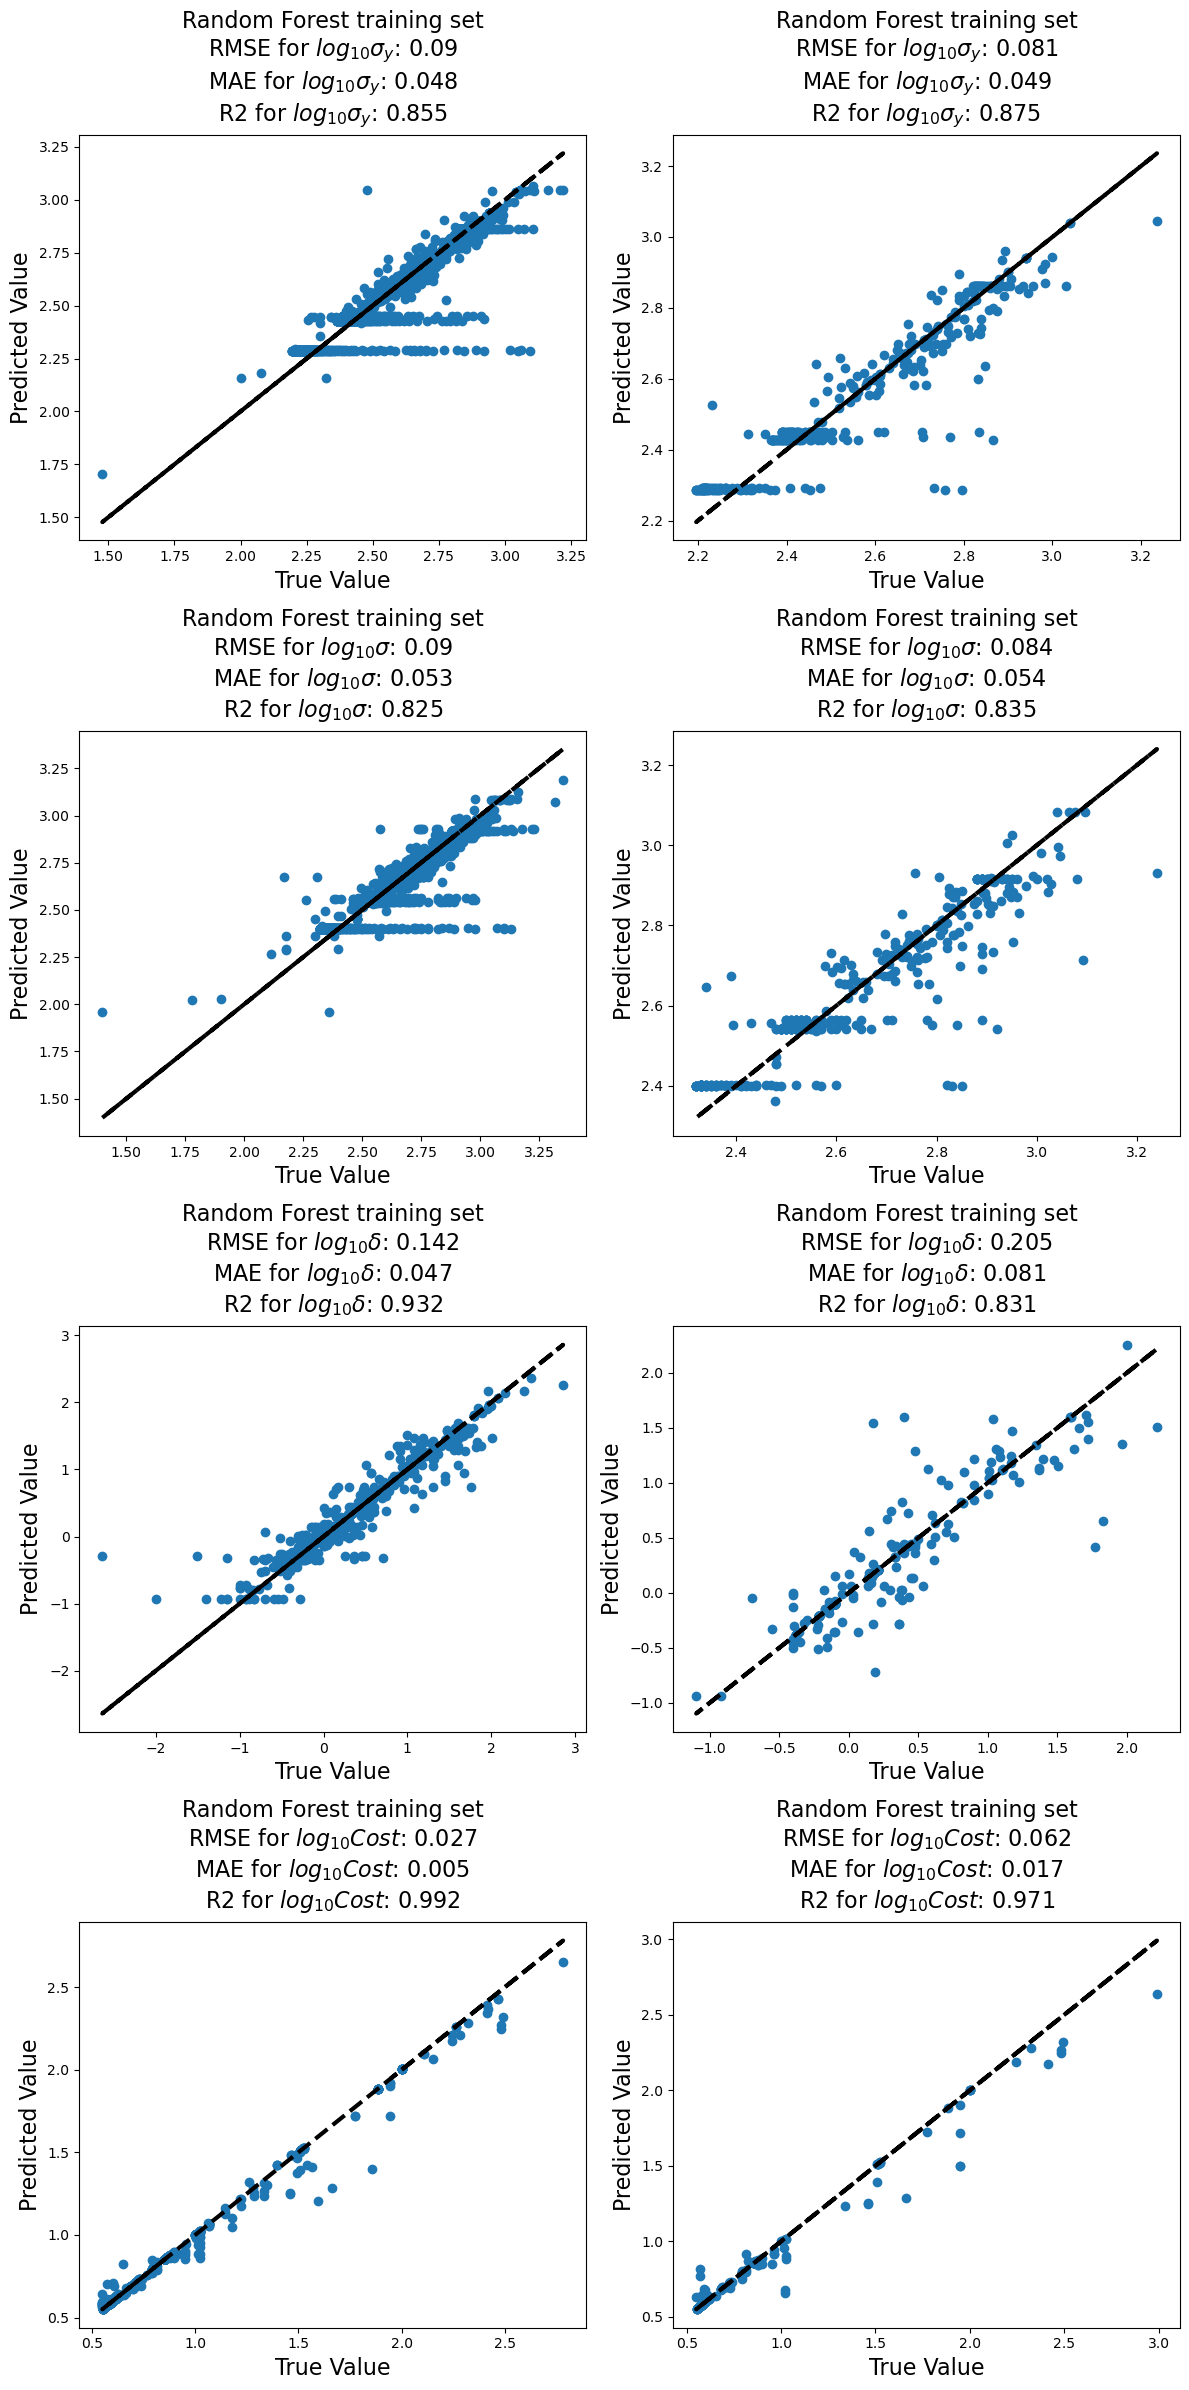

In [32]:
# Random Forest Regression
rfregressor = RandomForestRegressor(n_estimators=496, max_depth=26, random_state=0)

rfregressor.fit(X_train,y_train)
y_pred_train = rfregressor.predict(X_train)
y_pred_test = rfregressor.predict(X_test)

rmse, mae, R2 = plot('Random Forest', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Random Forest'] = rmse
mae_scores['Random Forest'] = mae
R2_scores['Random Forest'] = R2

In [16]:
# Get SHAP values
rfexplainer = shap.TreeExplainer(rfregressor)
rf_shap_values = rfexplainer(X_test)
np.shape(rf_shap_values.values)

(388, 21, 4)

### Global Interpretations

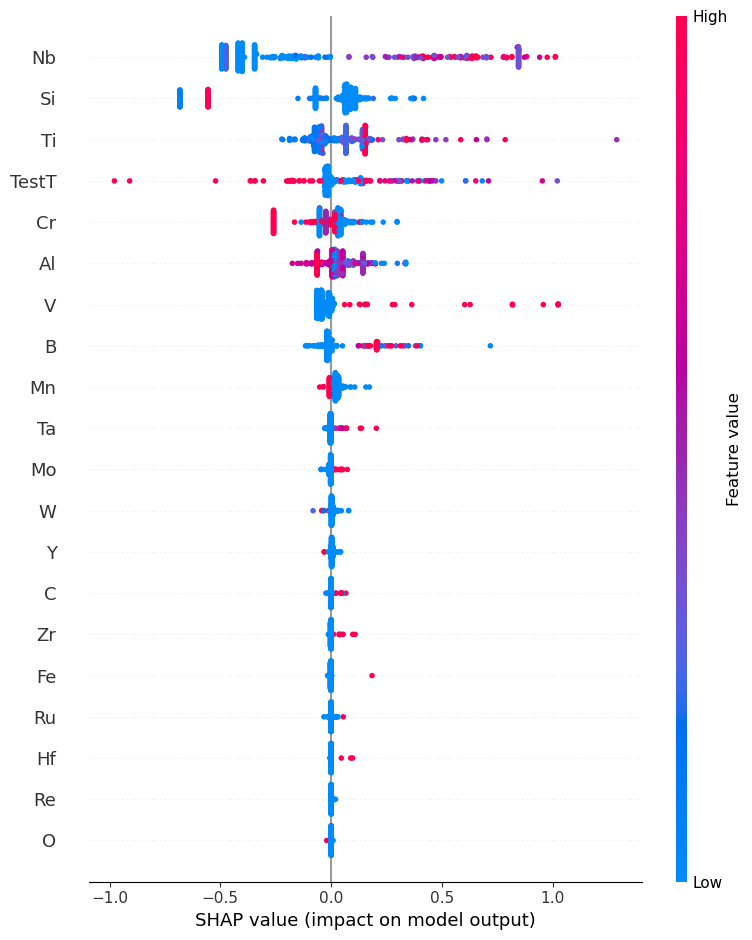

In [17]:
# Summary plot for logYS
shap.summary_plot(rf_shap_values[:,:,0])

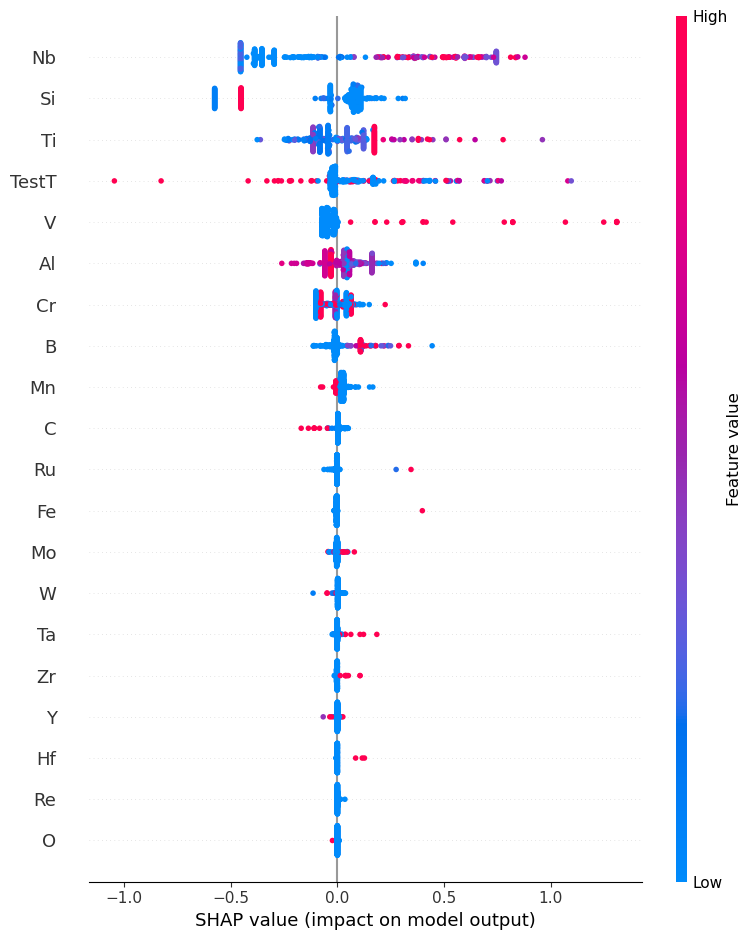

In [18]:
# Summary plot for logTS
shap.summary_plot(rf_shap_values[:,:,1])

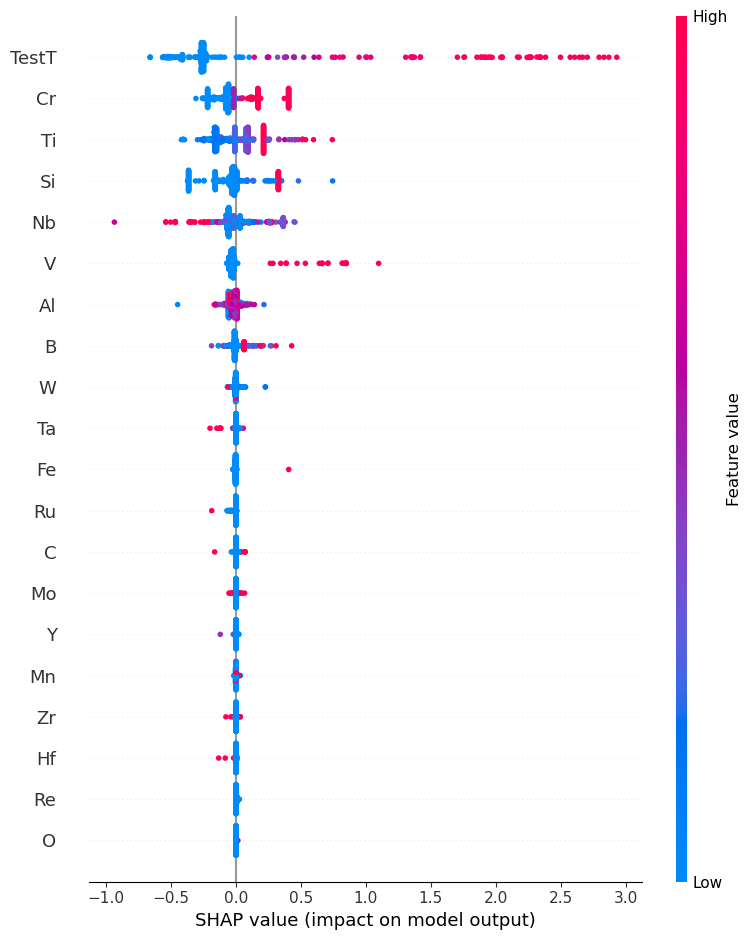

In [19]:
# Summary plot for logEl
shap.summary_plot(rf_shap_values[:,:,2])

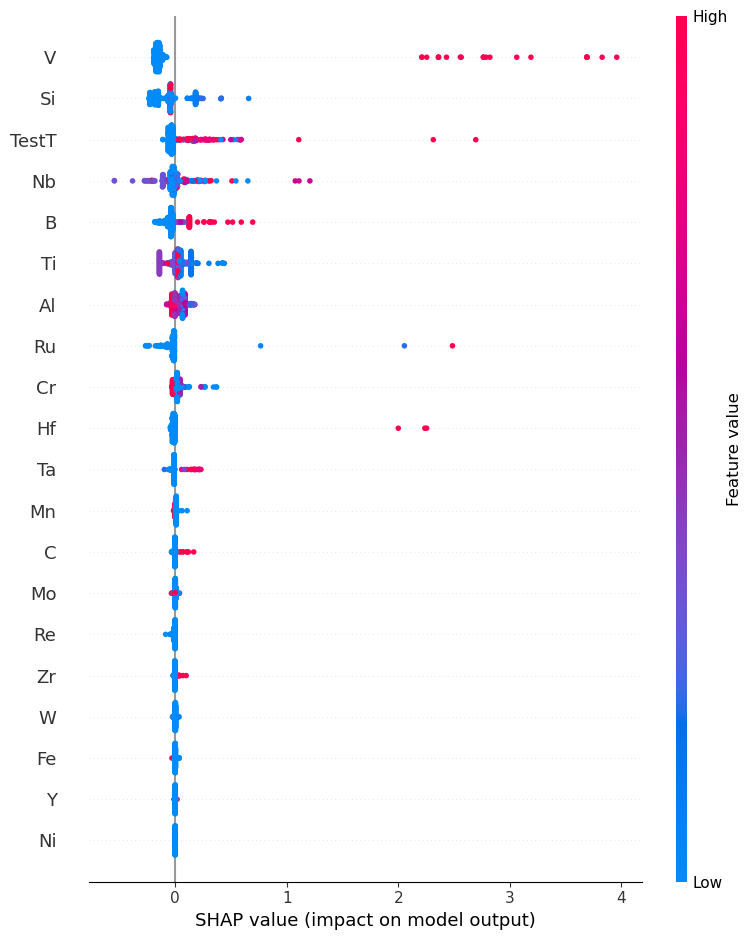

In [20]:
# Summary plot for logCost
shap.summary_plot(rf_shap_values[:,:,3])

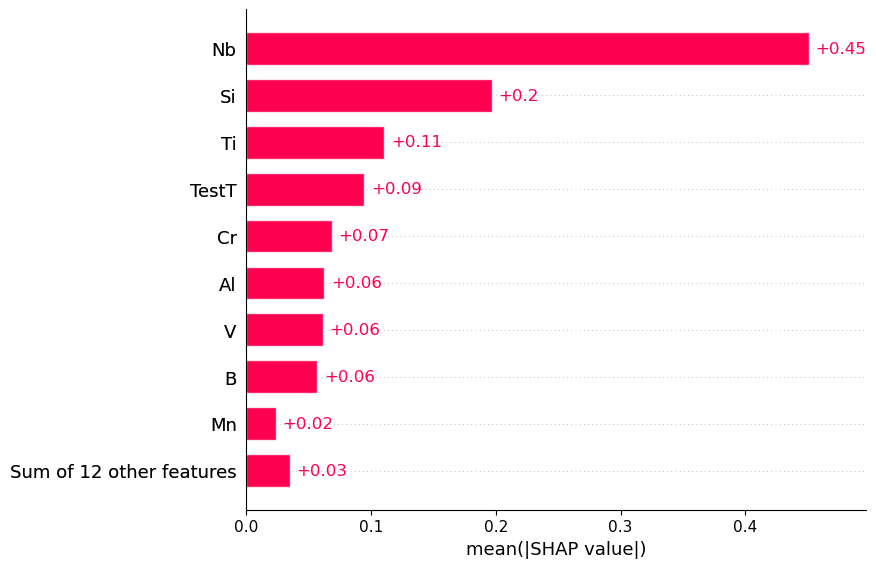

In [21]:
# Mean SHAP for logYS
shap.plots.bar(rf_shap_values[:,:,0])

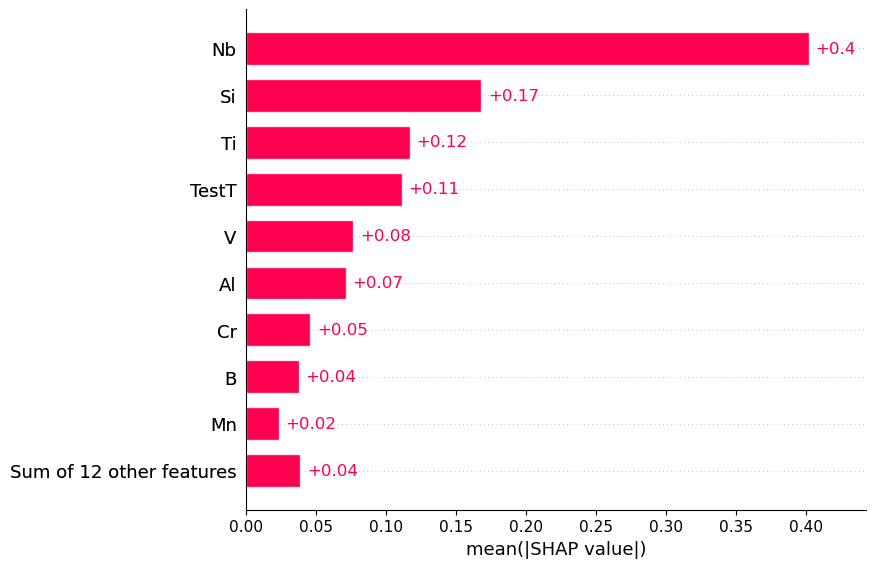

In [22]:
# Mean SHAP for logTS
shap.plots.bar(rf_shap_values[:,:,1])

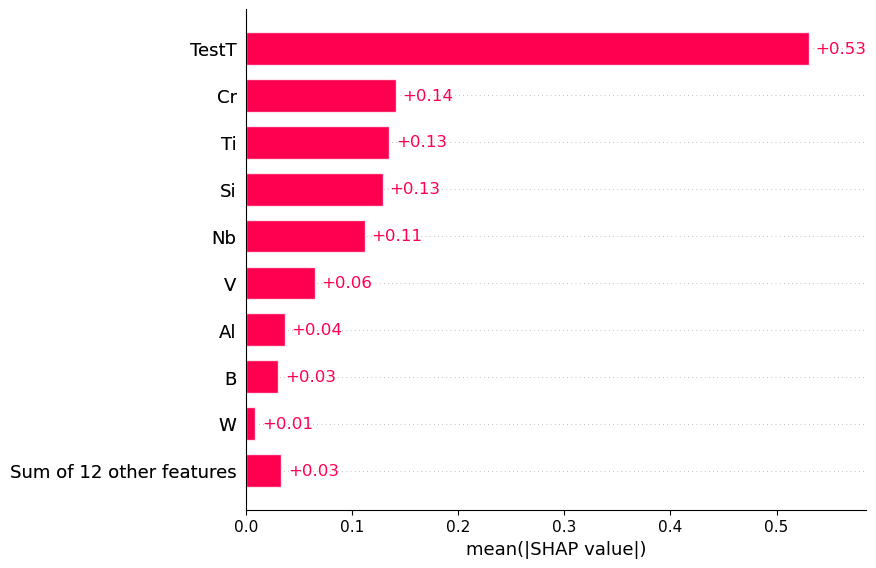

In [23]:
# Mean SHAP for logEl
shap.plots.bar(rf_shap_values[:,:,2])

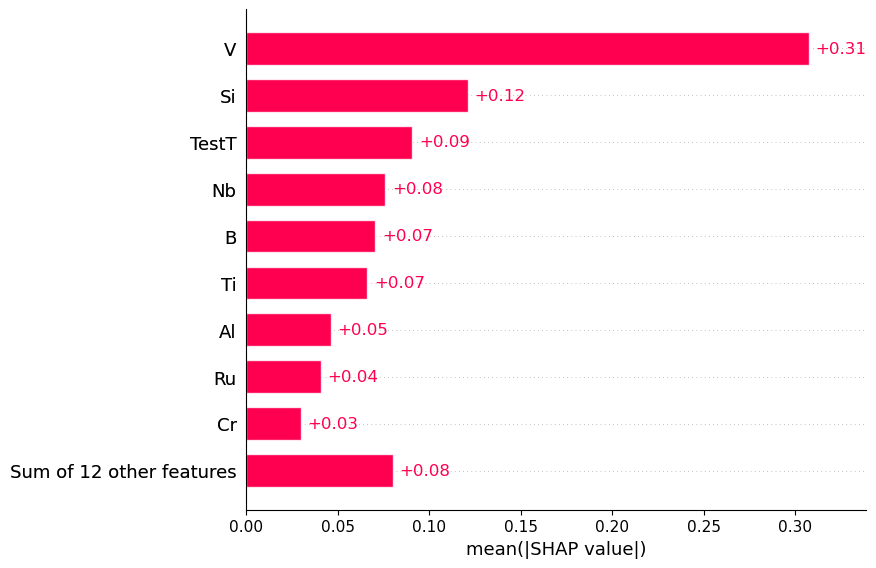

In [24]:
# Mean SHAP for logCost
shap.plots.bar(rf_shap_values[:,:,3])

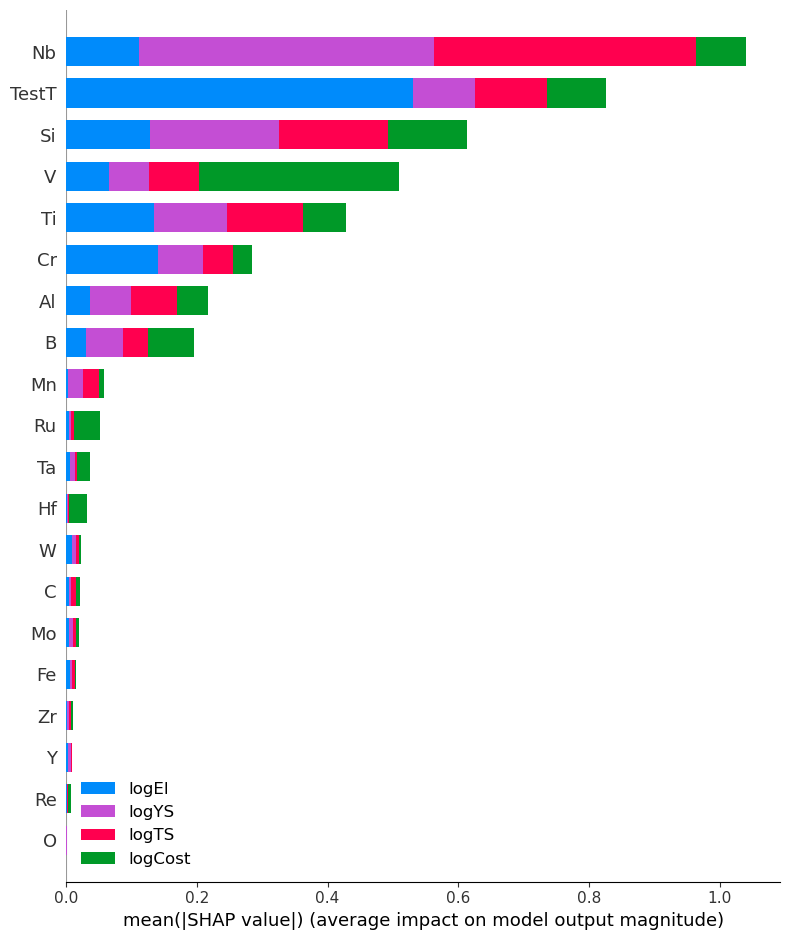

In [25]:
# Overall Summary plot
rf_shap_list = [rf_shap_values.values[:,:,0],rf_shap_values.values[:,:,1],rf_shap_values.values[:,:,2],rf_shap_values.values[:,:,3]]
shap.summary_plot(rf_shap_list, features=X_test, class_names=response)

### Local Interpretations

In [21]:
pd.DataFrame(np.round(scalerX.inverse_transform(X_test),3), columns=features).iloc[0,:]

Ti        50.0
Al        48.0
Mn         0.0
Nb         0.0
Cr         2.0
Mo         0.0
V          0.0
Zr         0.0
Hf         0.0
O          0.0
Ta        -0.0
Si         0.0
W          0.0
C          0.0
B          0.0
Fe         0.0
Ru         0.0
Ni         0.0
Y          0.0
Re         0.0
TestT    298.0
Name: 0, dtype: float64

In [22]:
pd.DataFrame(np.round(scalerX.inverse_transform(X_test),3), columns=features).iloc[99,:]

Ti         46.08
Al         45.00
Mn          0.00
Nb          8.50
Cr          0.00
Mo          0.00
V           0.00
Zr          0.00
Hf          0.00
O           0.00
Ta         -0.00
Si          0.00
W           0.20
C           0.00
B           0.20
Fe          0.00
Ru          0.00
Ni          0.00
Y           0.02
Re          0.00
TestT    1088.00
Name: 99, dtype: float64

In [34]:
pd.DataFrame(np.round(scalerY.inverse_transform(y_pred_test),3), columns=response).iloc[0,:]

logYS      2.427
logTS      2.542
logEl      0.191
logCost    0.589
Name: 0, dtype: float64

In [23]:
pd.DataFrame(np.round(scalerY.inverse_transform(y_test),3), columns=response).iloc[0,:]

logYS      2.392
logTS      2.510
logEl      0.190
logCost    0.589
Name: 0, dtype: float64

In [35]:
pd.DataFrame(np.round(scalerY.inverse_transform(y_pred_test),3), columns=response).iloc[99,:]

logYS      2.693
logTS      2.788
logEl      0.414
logCost    0.720
Name: 99, dtype: float64

In [24]:
pd.DataFrame(np.round(scalerY.inverse_transform(y_test),3), columns=response).iloc[99,:]

logYS      2.724
logTS      2.813
logEl      1.771
logCost    0.724
Name: 99, dtype: float64

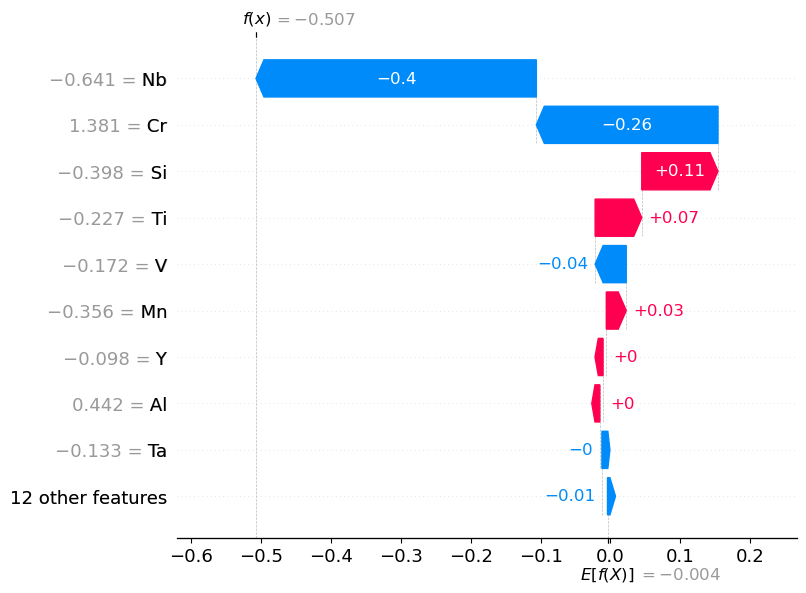

In [26]:
# Waterfall plot for logYS for the first test instance
shap.plots.waterfall(rf_shap_values[:,:,0][0])

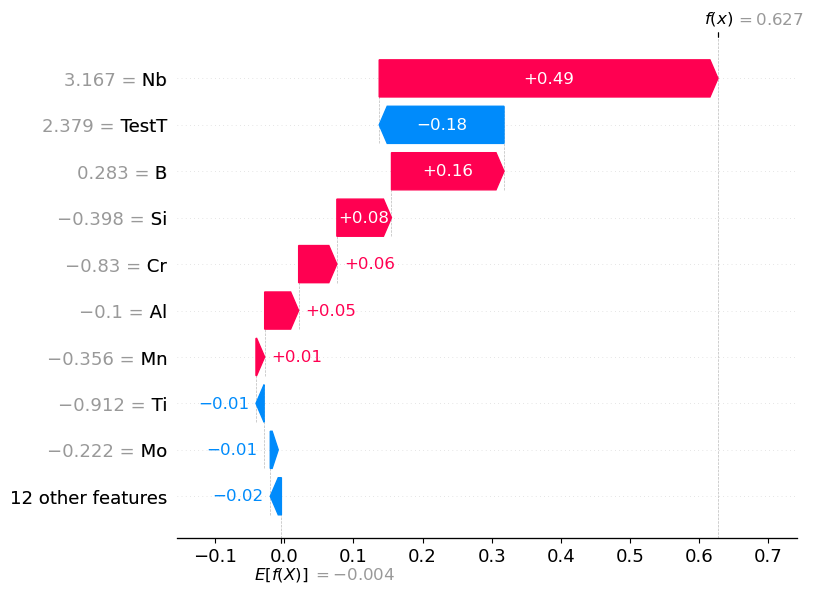

In [27]:
# Waterfall plot for logYS for the 100th test instance
shap.plots.waterfall(rf_shap_values[:,:,0][99])

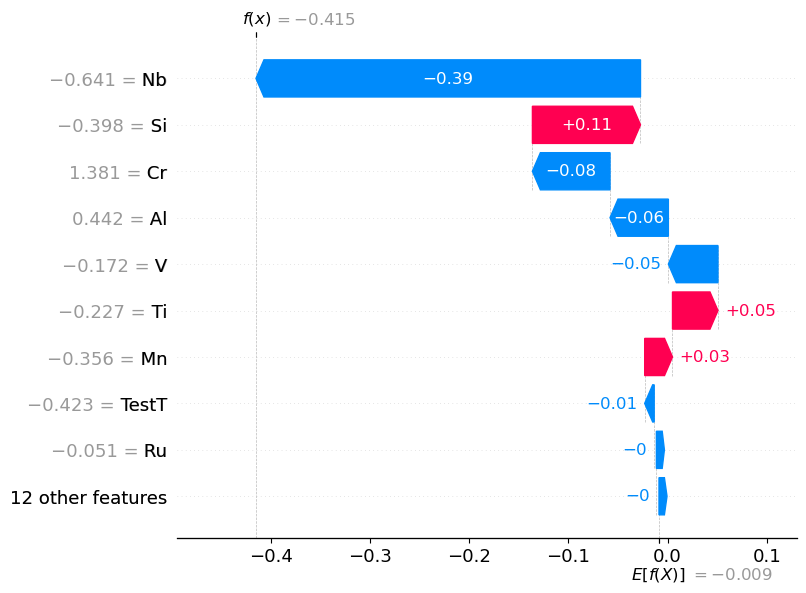

In [28]:
# Waterfall plot for logTS for the first test instance
shap.plots.waterfall(rf_shap_values[:,:,1][0])

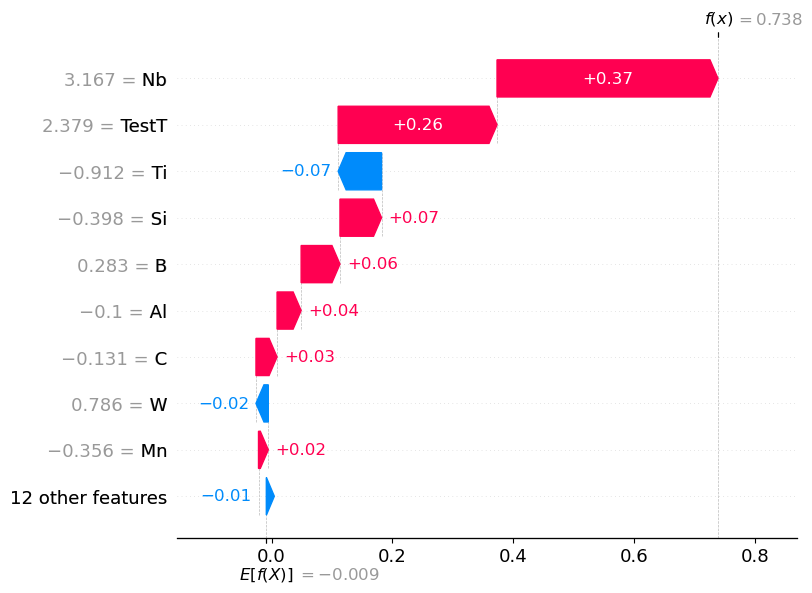

In [29]:
# Waterfall plot for logTS for the 100th test instance
shap.plots.waterfall(rf_shap_values[:,:,1][99])

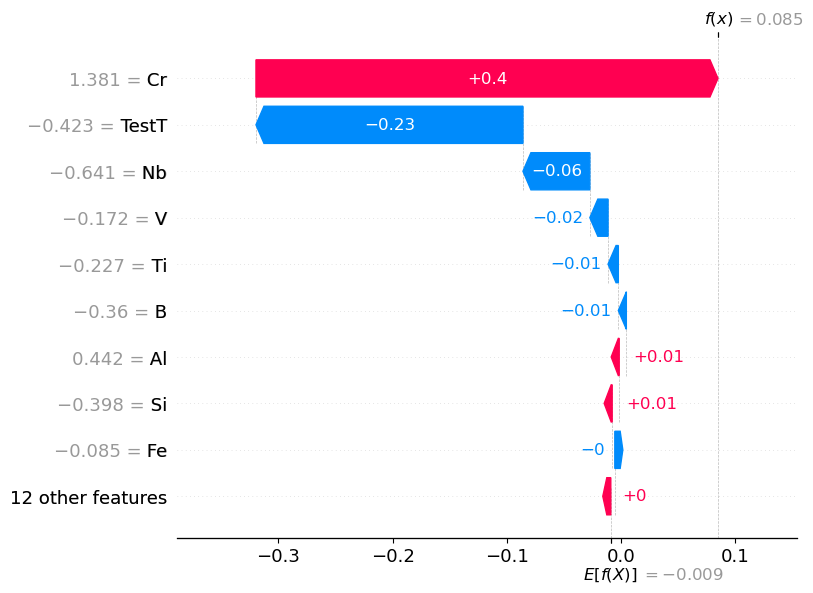

In [30]:
# Waterfall plot for logEl for the first test instance
shap.plots.waterfall(rf_shap_values[:,:,2][0])

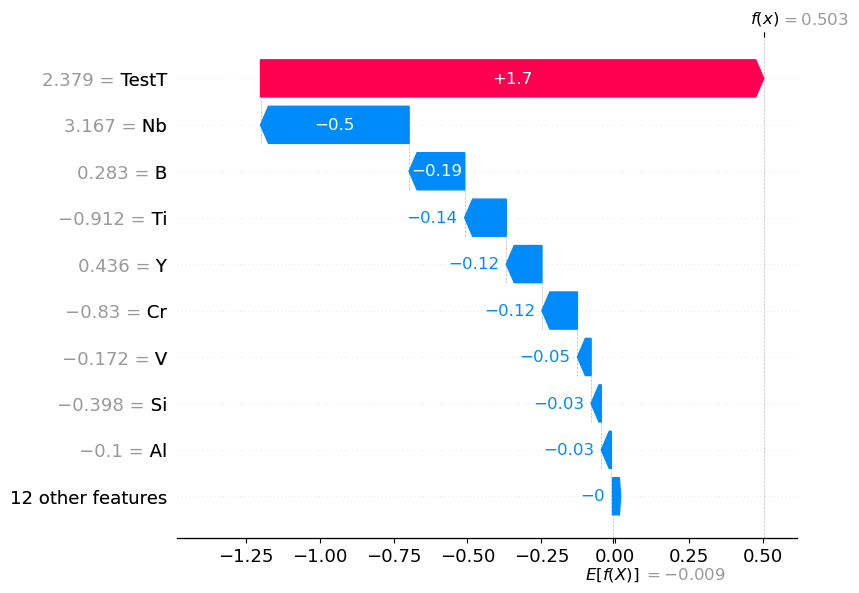

In [31]:
# Waterfall plot for logEl for the 100th test instance
shap.plots.waterfall(rf_shap_values[:,:,2][99])

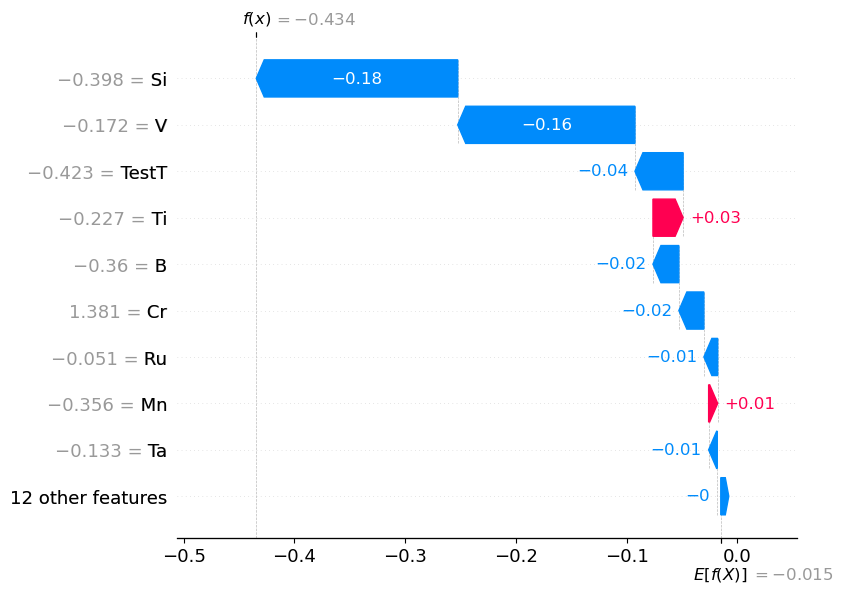

In [32]:
# Waterfall plot for logCost for the first test instance
shap.plots.waterfall(rf_shap_values[:,:,3][0])

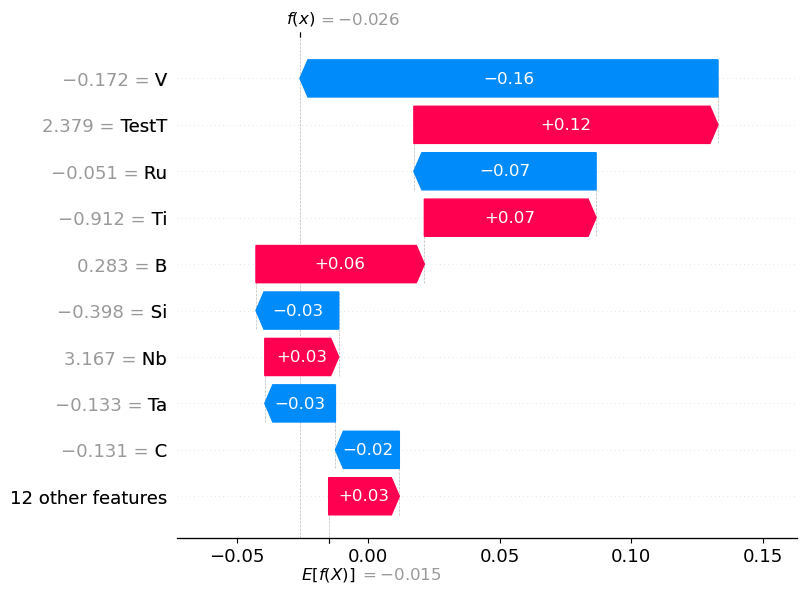

In [33]:
# Waterfall plot for logCost for the 100th test instance
shap.plots.waterfall(rf_shap_values[:,:,3][99])

### Bayesian Optimization

In [22]:
# Define our search space
x_space = [Real(0.01,100),Real(0.01,100),Integer(0,0.001),Real(0.01,10),Real(0.01,10)]
for i in range(5,20):
    x_space.append(Integer(0,0.001))
x_space.append(Integer(298,298.1))
x_space

[Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='id

In [23]:
def f(X):
    x_init = np.array(X).reshape(1,-1)
    comp = x_init[:-1]/sum(x_init[:-1])*100
    x = np.append(comp,x_init[-1]).reshape(1,-1)
    transformed = scalerX.transform(x)
    y_pred = rfregressor.predict(transformed)
    predicted = scalerY.inverse_transform(y_pred)
    
    target_err_1 = 0
    for i in range(len(target)):
        if target[i] != None:
            target_err_1 = target_err_1 + weight[i]*abs(target[i] - predicted[0][i])
    
    objective = target_err_1
    
    return objective

In [24]:
#Targets
targets = [[np.log10(700),np.log10(900),np.log10(4.5),np.log10(2.5)],
           [np.log10(700),np.log10(900),np.log10(4.5),np.log10(3)]]

In [25]:
targets_df = pd.DataFrame(targets)
targets_df.to_excel("MPR_RF_BO_Targets-RT.xlsx")

In [26]:
weight = [1, 1, 1, 1, 1, 1, 1]

In [27]:
fl_nm=[]
for i in range(len(targets)):
    fl_nm.append('wCostmod'+'-'+str(i+1))
fl_nm

['wCostmod-1', 'wCostmod-2']

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have val

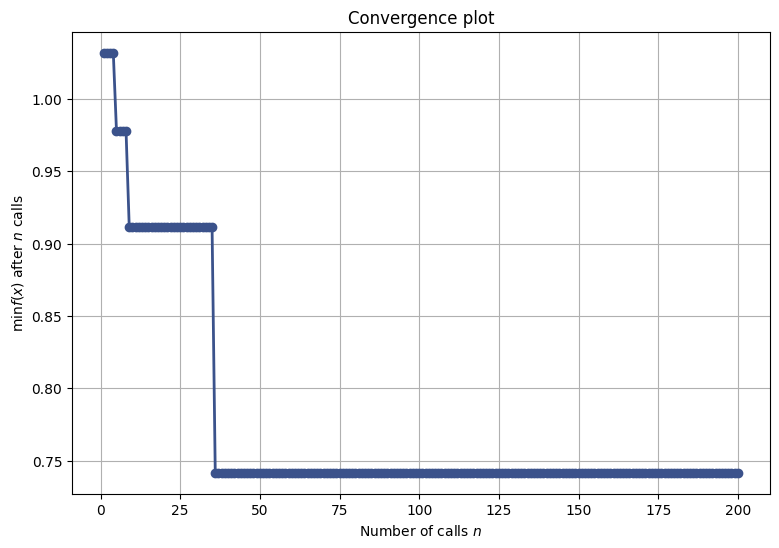

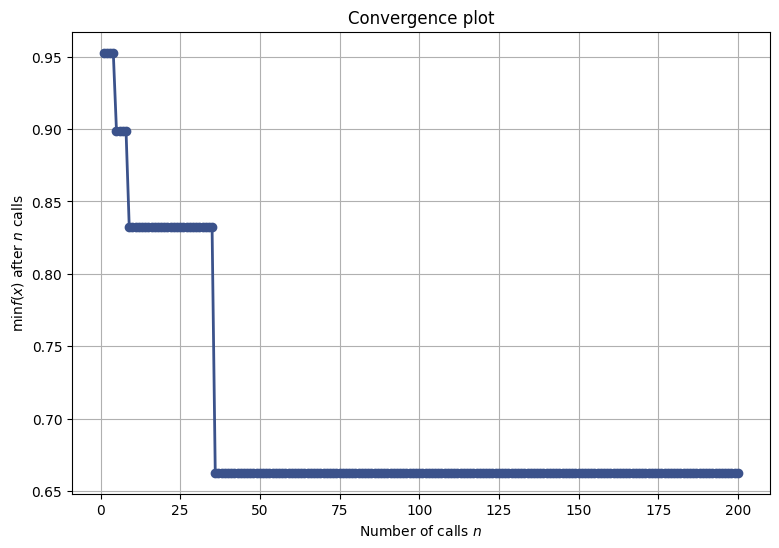

In [28]:
for i in range(len(targets)):
    target = targets[i]
    res = gp_minimize(f,                  # the function to minimize
                      x_space,      # the bounds on each dimension of x
                      acq_func="EI",      # the acquisition function
                      n_calls=200,         # the number of evaluations of f
                      n_random_starts=5,  # the number of random initialization points
                      random_state=42,   # the random seed
                      xi=0.01,           # Exploration or Exploitation
                      n_jobs=-1)
    
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    ax = plot_convergence(res)
    filename = f'Convergence_{i+1}_RFR.png'
    fig.savefig('Plots/'+filename)

    for j in range(200):
        results = res.x_iters[j]
        comp_res = np.round(results[:-1]/sum(results[:-1])*100,2)
        results_mod = np.append(comp_res,results[-1])
        temp1 = pd.DataFrame(results_mod.reshape(1,-1), columns=features, index=[j])
        transformed = scalerX.transform(temp1)
        y_pred = rfregressor.predict(transformed)
        predicted = scalerY.inverse_transform(y_pred)
        temp2 = pd.DataFrame(predicted, columns=response, index=[j])
        temp3 = pd.DataFrame(np.round(res.func_vals[j],2), columns = ['Objective'], index=[j])
        if j==0:
            temp_db = pd.concat([temp1,temp2,temp3],axis=1)
        else:
            temp4 = pd.concat([temp1,temp2,temp3],axis=1)
            temp_db = pd.concat([temp_db,temp4],axis=0)
    
    temp_db = temp_db.sort_values('Objective')
    res_df = temp_db.iloc[:10,:]
    temp_db.to_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'.xlsx')
    res_df.to_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'_top10.xlsx')

### Composition 1 Properties Prediction

In [ ]:
c1_data = pd.read_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_wCostmod-1.xlsx')
c1_data = c1_data.iloc[:10,1:22]
c1_data

Ti     Al  Mn    Nb    Cr  Mo  V  Zr  Hf  O  ...  Si  W  C  B  Fe  Ru  \
0  63.67  30.86   0  2.14  3.34   0  0   0   0  0  ...   0  0  0  0   0   0   
1  41.61  48.66   0  4.87  4.87   0  0   0   0  0  ...   0  0  0  0   0   0   
2  44.15  49.47   0  1.43  4.95   0  0   0   0  0  ...   0  0  0  0   0   0   
3  34.44  60.02   0  1.87  3.67   0  0   0   0  0  ...   0  0  0  0   0   0   
4  43.38  48.06   0  4.81  3.76   0  0   0   0  0  ...   0  0  0  0   0   0   
5  40.30  54.01   0  1.62  4.08   0  0   0   0  0  ...   0  0  0  0   0   0   
6  41.85  53.46   0  2.17  2.52   0  0   0   0  0  ...   0  0  0  0   0   0   
7  46.37  49.13   0  1.93  2.57   0  0   0   0  0  ...   0  0  0  0   0   0   
8  39.11  52.89   0  5.29  2.71   0  0   0   0  0  ...   0  0  0  0   0   0   
9  47.33  47.33   0  2.92  2.43   0  0   0   0  0  ...   0  0  0  0   0   0   

   Ni  Y  Re  TestT  
0   0  0   0    298  
1   0  0   0    298  
2   0  0   0    298  
3   0  0   0    298  
4   0  0   0    298  
5   0  0   0    298  
6   0  0   0    298  
7   0  0   0    298  
8   0  0   0    298  
9   0  0   0    298  

[10 rows x 21 columns]

In [30]:
c1_mean = round(c1_data.mean(axis=0),2)
c1_mean

Ti        44.22
Al        49.39
Mn         0.00
Nb         2.90
Cr         3.49
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [31]:
c1_mean_scaled = scalerX.transform(c1_mean.values.reshape(1,-1))
c1_prop_scaled = rfregressor.predict(c1_mean_scaled)
c1_prop = scalerY.inverse_transform(c1_prop_scaled)
c1_prop = np.round(10**c1_prop, 2)
c1_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[498.32, 580.  ,   0.67,   4.25]])

In [32]:
c1_prop_df = pd.DataFrame(c1_prop, columns=['YS','TS','El','Cost'])
c1_prop_df

YS     TS    El  Cost
0  498.32  580.0  0.67  4.25

In [ ]:
c1_prop_df.to_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_wCostmod-1_top10_Properties.xlsx')

### Composition 2 Properties Prediction

In [ ]:
c2_data = pd.read_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_wCostmod-2.xlsx')
c2_data = c2_data.iloc[:10,1:22]
c2_data

Ti     Al  Mn    Nb    Cr  Mo  V  Zr  Hf  O  ...  Si  W  C  B  Fe  Ru  \
0  63.67  30.86   0  2.14  3.34   0  0   0   0  0  ...   0  0  0  0   0   0   
1  44.37  48.12   0  4.81  2.70   0  0   0   0  0  ...   0  0  0  0   0   0   
2  37.42  56.13   0  1.73  4.72   0  0   0   0  0  ...   0  0  0  0   0   0   
3  55.22  35.14   0  4.02  5.63   0  0   0   0  0  ...   0  0  0  0   0   0   
4  47.90  45.54   0  2.91  3.66   0  0   0   0  0  ...   0  0  0  0   0   0   
5  37.84  53.42   0  5.34  3.40   0  0   0   0  0  ...   0  0  0  0   0   0   
6  40.56  54.67   0  1.98  2.79   0  0   0   0  0  ...   0  0  0  0   0   0   
7  47.71  47.70   0  1.41  3.19   0  0   0   0  0  ...   0  0  0  0   0   0   
8  38.36  53.19   0  3.13  5.32   0  0   0   0  0  ...   0  0  0  0   0   0   
9  47.28  47.28   0  2.08  3.35   0  0   0   0  0  ...   0  0  0  0   0   0   

   Ni  Y  Re  TestT  
0   0  0   0    298  
1   0  0   0    298  
2   0  0   0    298  
3   0  0   0    298  
4   0  0   0    298  
5   0  0   0    298  
6   0  0   0    298  
7   0  0   0    298  
8   0  0   0    298  
9   0  0   0    298  

[10 rows x 21 columns]

In [35]:
c2_mean = round(c2_data.mean(axis=0),2)
c2_mean

Ti        46.03
Al        47.21
Mn         0.00
Nb         2.95
Cr         3.81
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [36]:
c2_mean_scaled = scalerX.transform(c2_mean.values.reshape(1,-1))
c2_prop_scaled = rfregressor.predict(c2_mean_scaled)
c2_prop = scalerY.inverse_transform(c2_prop_scaled)
c2_prop = np.round(10**c2_prop, 2)
c2_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[490.68, 582.31,   1.01,   4.86]])

In [37]:
c2_prop_df = pd.DataFrame(c2_prop, columns=['YS','TS','El','Cost'])
c2_prop_df

YS      TS    El  Cost
0  490.68  582.31  1.01  4.86

In [ ]:
c2_prop_df.to_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_wCostmod-2_top10_Properties.xlsx')

### Reference Composition Properties

In [39]:
ref_comp = [48, 48, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298]
ref_comp = np.array(ref_comp).reshape(1,-1)
ref_comp_df = pd.DataFrame(ref_comp, columns=features)
ref_comp_df

Ti  Al  Mn  Nb  Cr  Mo  V  Zr  Hf  O  ...  Si  W  C  B  Fe  Ru  Ni  Y  Re  \
0  48  48   0   2   2   0  0   0   0  0  ...   0  0  0  0   0   0   0  0   0   

   TestT  
0    298  

[1 rows x 21 columns]

In [40]:
ref_comp_scaled = scalerX.transform(ref_comp)
ref_prop_scaled = rfregressor.predict(ref_comp_scaled)
ref_prop = scalerY.inverse_transform(ref_prop_scaled)
ref_prop = np.round(10**ref_prop, 2)
ref_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[456.61, 517.94,   0.52,   3.87]])

In [41]:
ref_prop_df = pd.DataFrame(ref_prop, columns=['YS','TS','El','Cost'])
ref_prop_df

YS      TS    El  Cost
0  456.61  517.94  0.52  3.87

In [ ]:
ref_prop_df.to_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_Ref_Properties.xlsx')

## MPR DNN model and BO

### Running 1st time

In [30]:
# Importing libraries for Neural Network Regression
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras import Sequential
from keras.layers import InputLayer, Dense, BatchNormalization

2025-06-23 23:51:35.908054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750740695.993052  176224 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750740696.020511  176224 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750740696.236399  176224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750740696.236428  176224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750740696.236431  176224 computation_placer.cc:177] computation placer alr

In [31]:
# Storing the hyperparameters in variable to develop the NN architecture
num_dense_layers = 11
units = 1029
activation = 'relu'
learning_rate = 4.161731258030334e-05
optimizer = 'Adam'
batchsize = 78
epochs = 100

In [32]:
# function to develop NN architecture with same number of units in all hidden layers
def build_and_compile_model(num_dense_layers,units,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
        model.add(Dense(units,activation=activation,name=name)) #add hidden layer(s)
    model.add(Dense(y_train.shape[1], activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [33]:
# Create the neural network with these hyper-parameters.
model1 = build_and_compile_model(num_dense_layers, units, activation, learning_rate, optimizer)
    
# Train the model.
history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, validation_split=0.2, verbose=0)

/home/shakti/miniconda3/envs/tf_ml_dl_env/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1750740700.985614  176224 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1750740705.414951  176448 service.cc:152] XLA service 0x7374fc016b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750740705.415010  176448 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-06-23 23:51:45.637025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750740706.356969  176448 cuda_dnn.cc:5

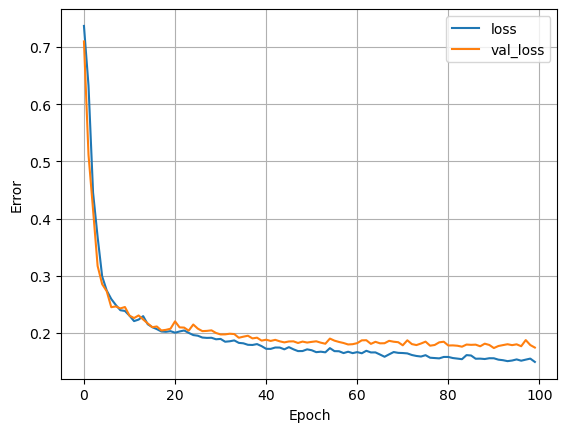

In [34]:
#function to plot the training and validation history of the NN
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

2025-06-23 23:53:30.598319: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 192 bytes spill stores, 192 bytes spill loads

2025-06-23 23:53:30.912368: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 628 bytes spill stores, 628 bytes spill loads

2025-06-23 23:53:31.067016: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 152 bytes spill stores, 152 bytes spill loads

2025-06-23 23:53:31.918690: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34_0', 100 bytes spill stores, 100 bytes spill loads

2025-06-23 23:53:32.627611: I external

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-06-23 23:53:40.992198: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 384 bytes spill stores, 384 bytes spill loads

2025-06-23 23:53:41.443844: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 172 bytes spill stores, 180 bytes spill loads

2025-06-23 23:53:41.828310: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 180 bytes spill stores, 180 bytes spill loads

2025-06-23 23:53:42.006581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 152 bytes spill stores, 152 bytes spill loads

2025-06-23 23:53:42.457171: I external/l

49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

2025-06-23 23:53:48.395789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 408 bytes spill stores, 408 bytes spill loads

2025-06-23 23:53:48.868781: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 184 bytes spill stores, 184 bytes spill loads

2025-06-23 23:53:49.313661: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 168 bytes spill stores, 168 bytes spill loads

2025-06-23 23:53:50.118114: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 980 bytes spill stores, 980 bytes spill loads

2025-06-23 23:53:50.725561: I external/l

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 573ms/step


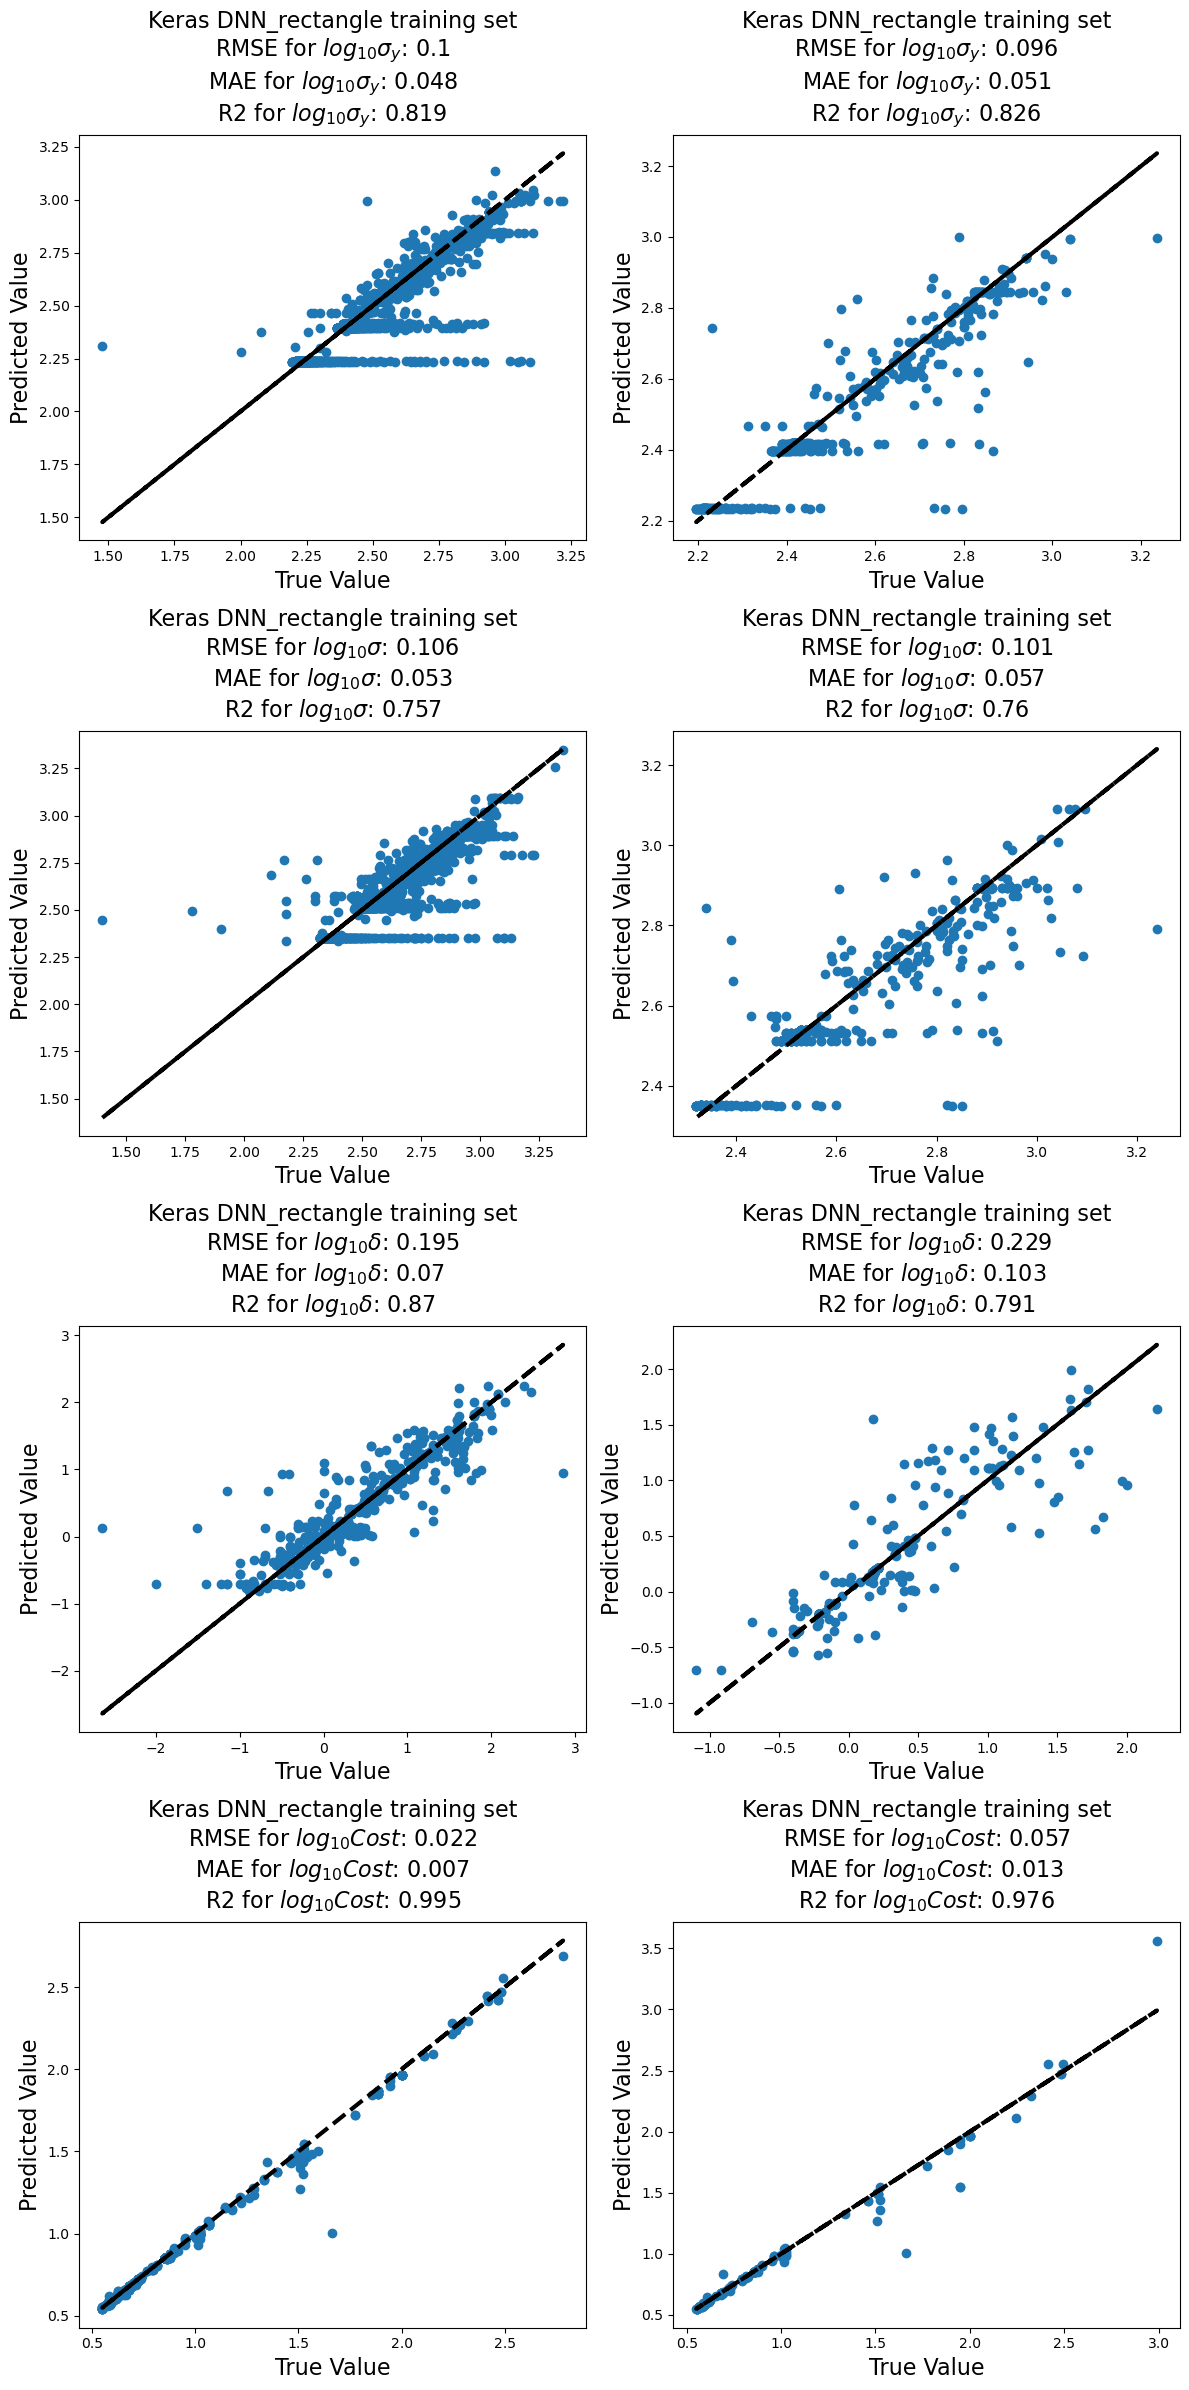

In [35]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model1.predict(X_train)
y_pred_test=model1.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_rectangle', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_rectangle'] = rmse
mae_scores['Keras DNN_rectangle'] = mae
R2_scores['Keras DNN_rectangle'] = R2

In [38]:
model1.save('MPR DNNrect model.h5')

### Loading the saved model

In [34]:
import tensorflow as tf

2025-06-23 23:57:25.209445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750741045.304760  179421 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750741045.335696  179421 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750741045.500864  179421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750741045.500898  179421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750741045.500900  179421 computation_placer.cc:177] computation placer alr

In [35]:
dnn_rect_model = tf.keras.models.load_model("MPR DNNrect model.h5")
dnn_rect_model.summary()

I0000 00:00:1750741049.378051  179421 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_dense_1 (Dense)           │ (None, 1029)           │        22,638 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_2 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_3 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_4 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_5 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_6 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_7 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_8 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_9 (Dense)           │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_10 (Dense)          │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_11 (Dense)          │ (None, 1029)           │     1,059,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625,460 (40.53 MB)

 Trainable params: 10,625,458 (40.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

I0000 00:00:1750741050.728837  179591 service.cc:152] XLA service 0x78df58004240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750741050.728890  179591 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-06-23 23:57:30.740357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750741050.817020  179591 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-23 23:57:31.607700: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 192 bytes spill stores, 192 bytes spill loads

2025-06-23 23:57:31.853190: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fu

40/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

I0000 00:00:1750741060.667347  179591 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-23 23:57:41.493837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 384 bytes spill stores, 384 bytes spill loads

2025-06-23 23:57:41.841891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 180 bytes spill stores, 180 bytes spill loads

2025-06-23 23:57:42.771921: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 744 bytes spill stores, 744 bytes spill loads

2025-06-23 23:57:42.816871: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

2025-06-23 23:57:49.121605: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 408 bytes spill stores, 408 bytes spill loads

2025-06-23 23:57:49.852054: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 184 bytes spill stores, 184 bytes spill loads

2025-06-23 23:57:50.265419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 168 bytes spill stores, 168 bytes spill loads

2025-06-23 23:57:50.962332: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 584 bytes spill stores, 584 bytes spill loads

2025-06-23 23:57:51.586739: I external/l

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step


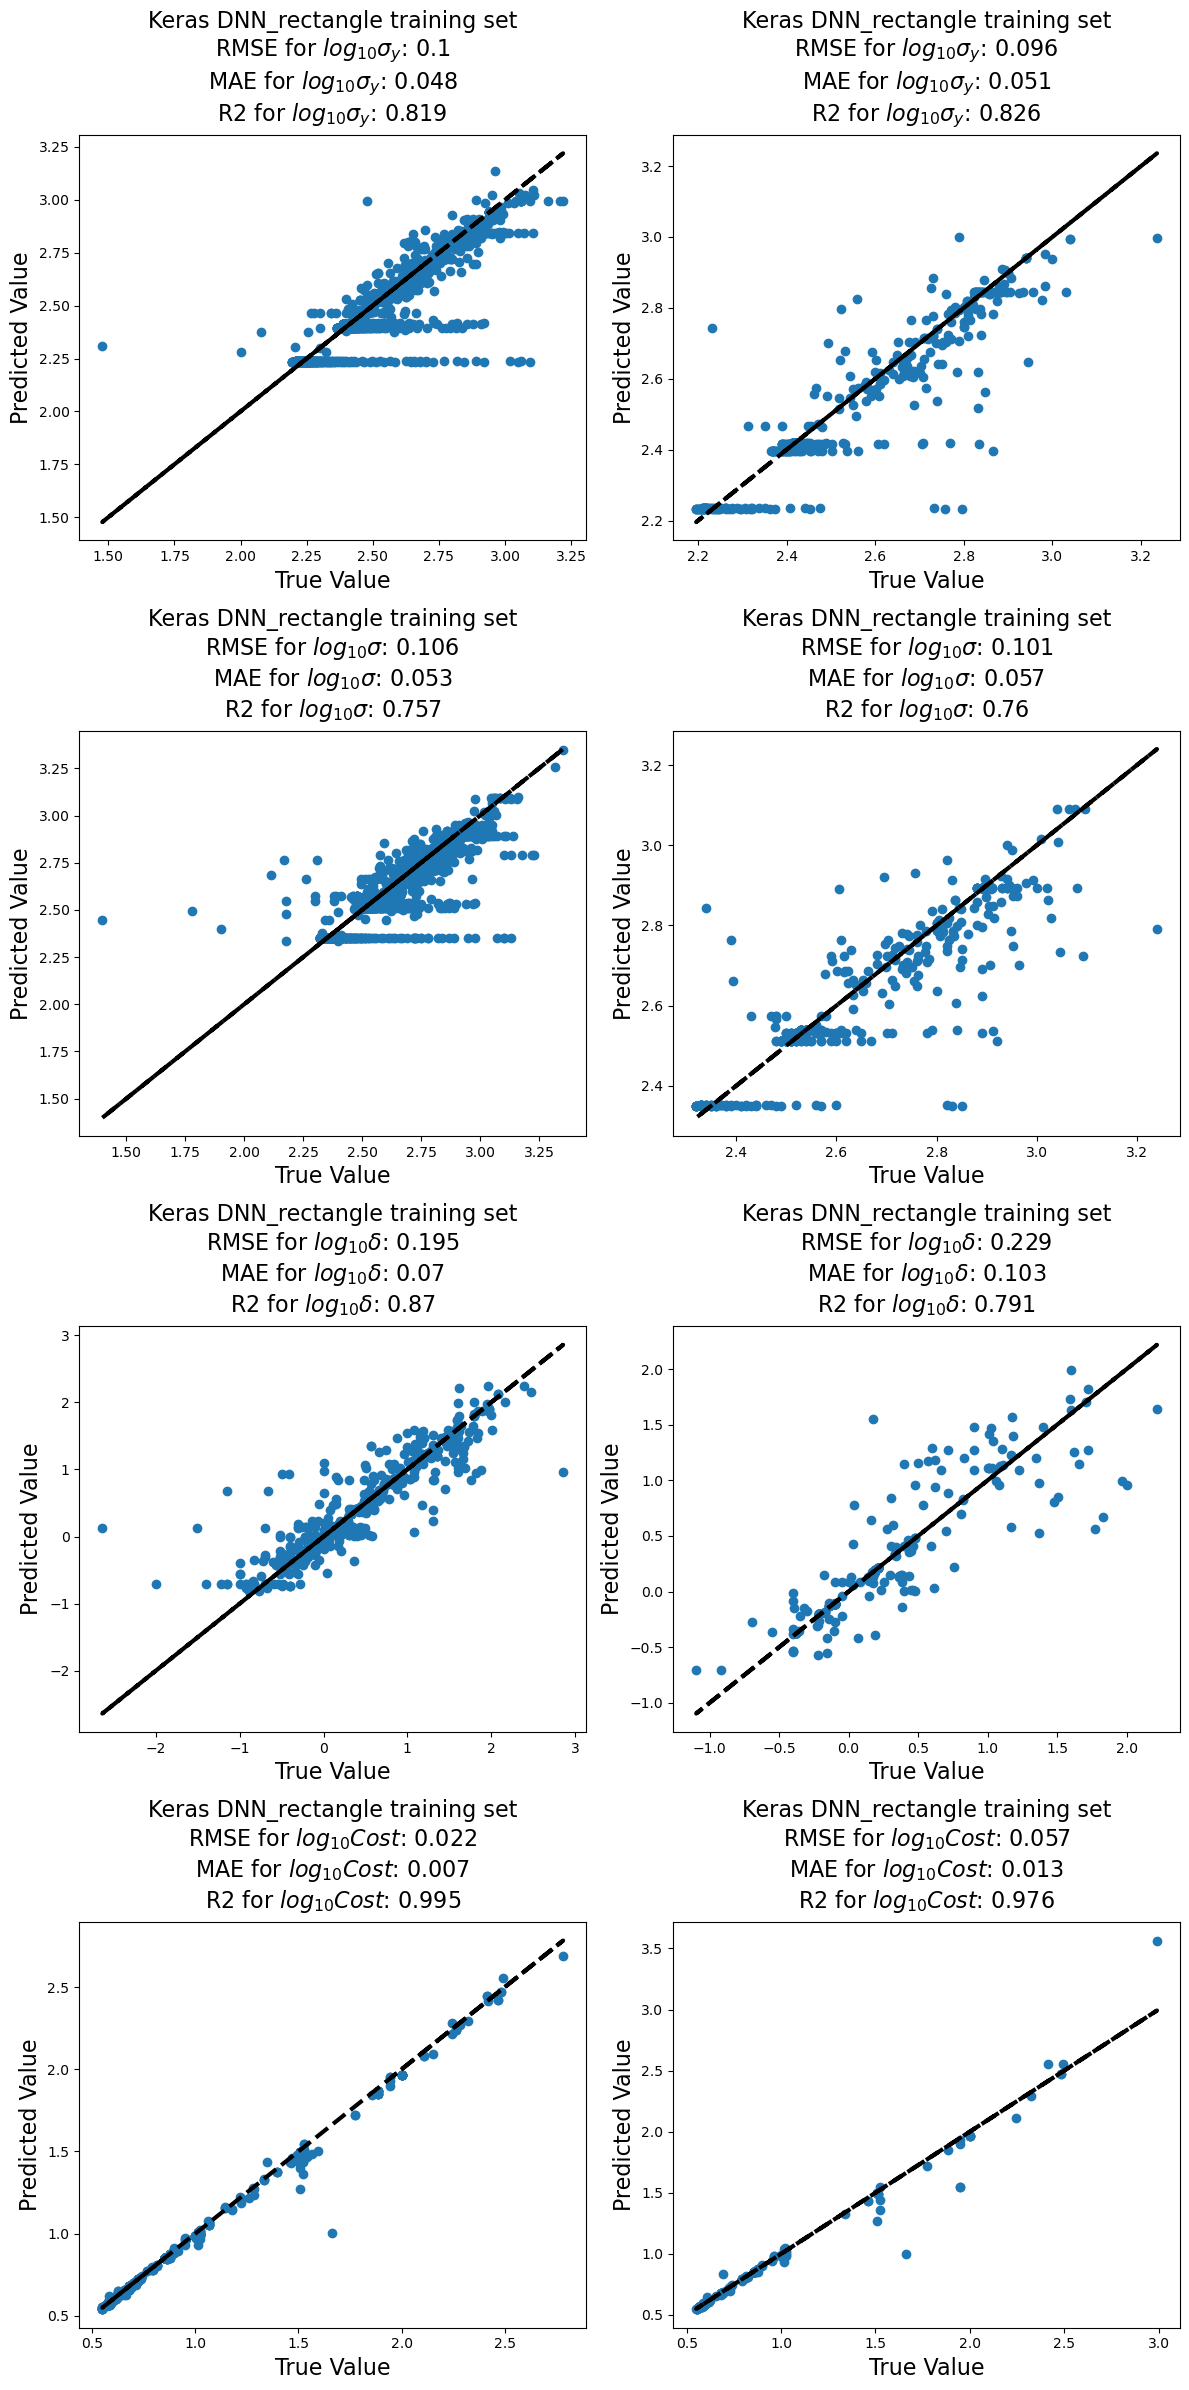

In [36]:
# Use the saved Keras model to predict on the training and test sets
y_pred_train=dnn_rect_model.predict(X_train)
y_pred_test=dnn_rect_model.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_rectangle', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_rectangle'] = rmse
mae_scores['Keras DNN_rectangle'] = mae
R2_scores['Keras DNN_rectangle'] = R2

In [37]:
# Get SHAP values
dnnexplainer = shap.KernelExplainer(dnn_rect_model.predict, X_train.iloc[:100,:])
dnn_shap_values = dnnexplainer(X_test.iloc[:100,:])
np.shape(dnn_shap_values)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
6495/6507 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-06-23 23:58:21.028344: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 400 bytes spill stores, 400 bytes spill loads

2025-06-23 23:58:21.526184: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 176 bytes spill stores, 176 bytes spill loads

2025-06-23 23:58:22.139351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 168 bytes spill stores, 168 bytes spill loads

2025-06-23 23:58:22.800933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 976 bytes spill stores, 976 bytes spill loads

2025-06-23 23:58:23.344856: I external/l

6507/6507 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6507/6507 ━━━━━━

2025-06-24 00:06:51.564839: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 368 bytes spill stores, 368 bytes spill loads

2025-06-24 00:06:52.521733: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 192 bytes spill stores, 192 bytes spill loads

2025-06-24 00:06:53.219124: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 152 bytes spill stores, 152 bytes spill loads

2025-06-24 00:06:53.285949: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 580 bytes spill stores, 580 bytes spill loads

2025-06-24 00:06:53.745340: I external/l

6513/6513 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6507/6507 ━━━━━━

(100, 21, 4)

### Global Interpretations

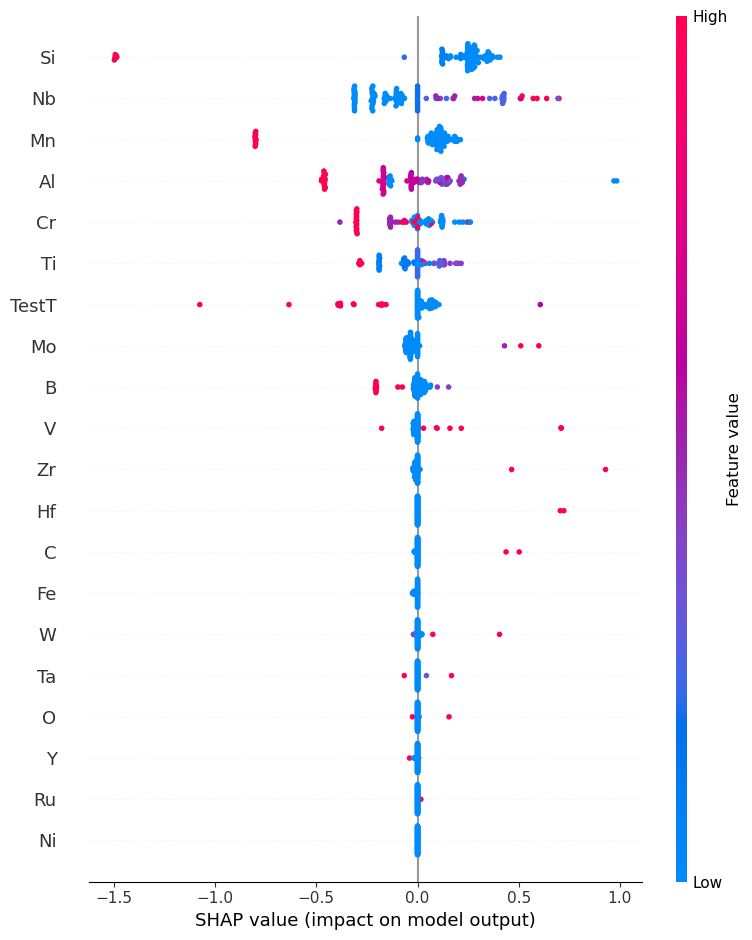

In [38]:
# Summary plot for logYS
shap.summary_plot(dnn_shap_values[:,:,0])

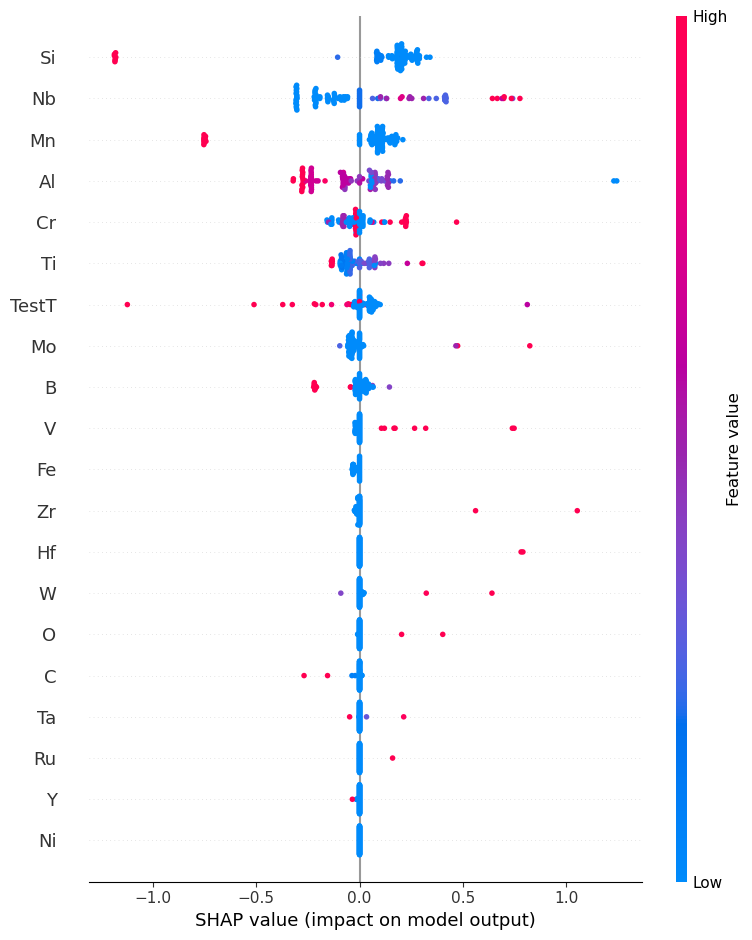

In [39]:
# Summary plot for logTS
shap.summary_plot(dnn_shap_values[:,:,1])

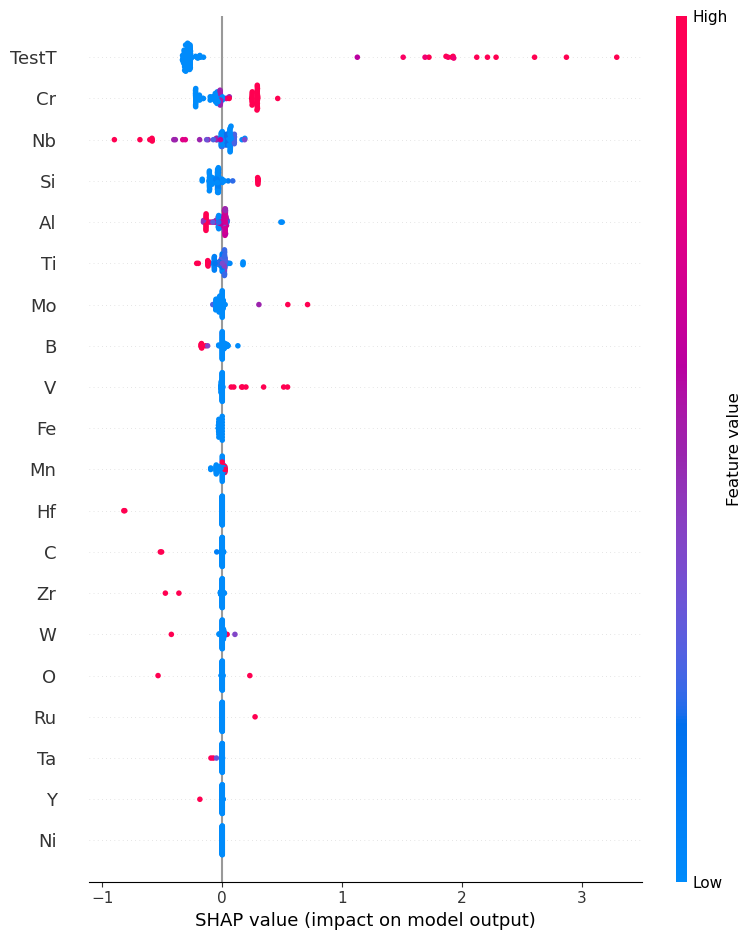

In [40]:
# Summary plot for logEl
shap.summary_plot(dnn_shap_values[:,:,2])

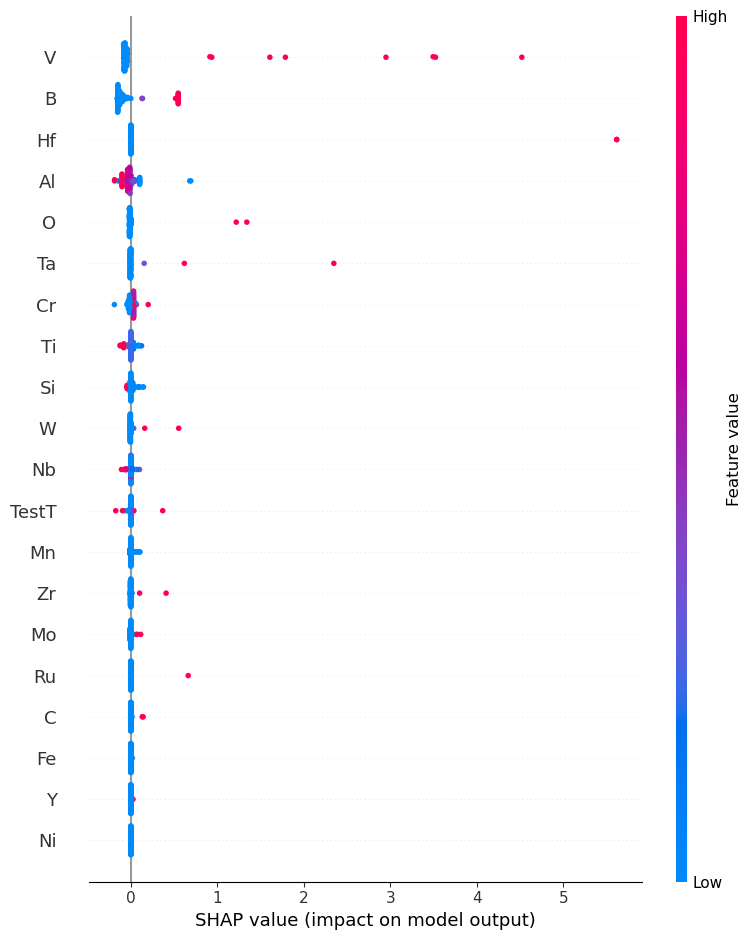

In [41]:
# Summary plot for logCost
shap.summary_plot(dnn_shap_values[:,:,3])

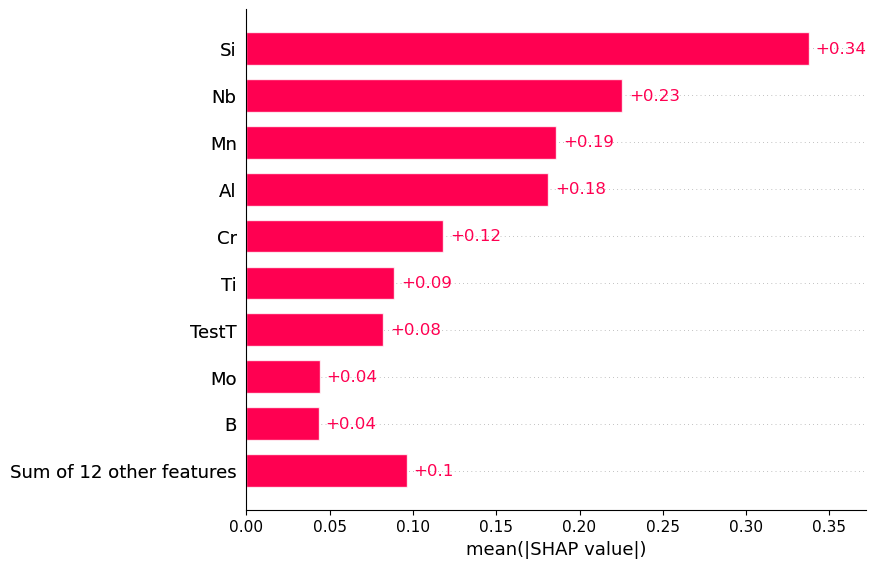

In [42]:
# Mean SHAP for logYS
shap.plots.bar(dnn_shap_values[:,:,0])

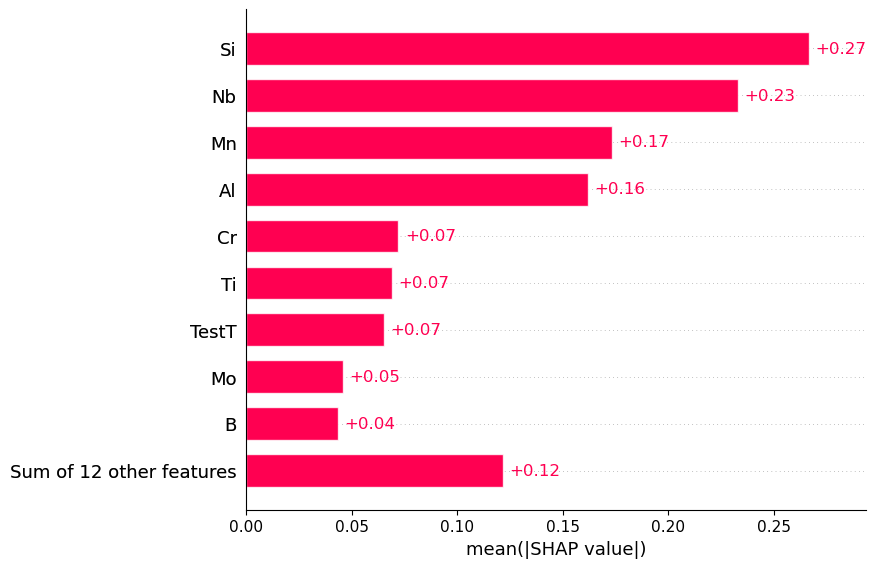

In [43]:
# Mean SHAP for logTS
shap.plots.bar(dnn_shap_values[:,:,1])

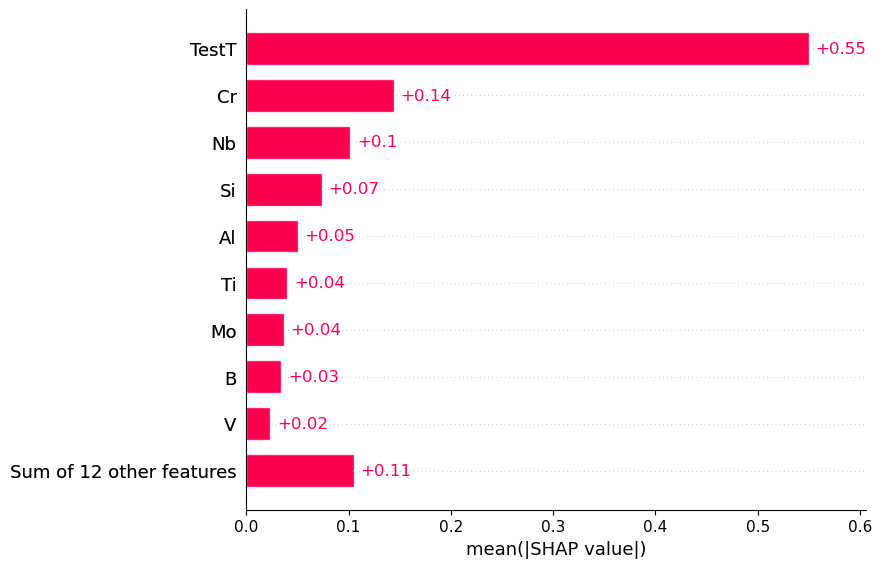

In [44]:
# Mean SHAP for logEl
shap.plots.bar(dnn_shap_values[:,:,2])

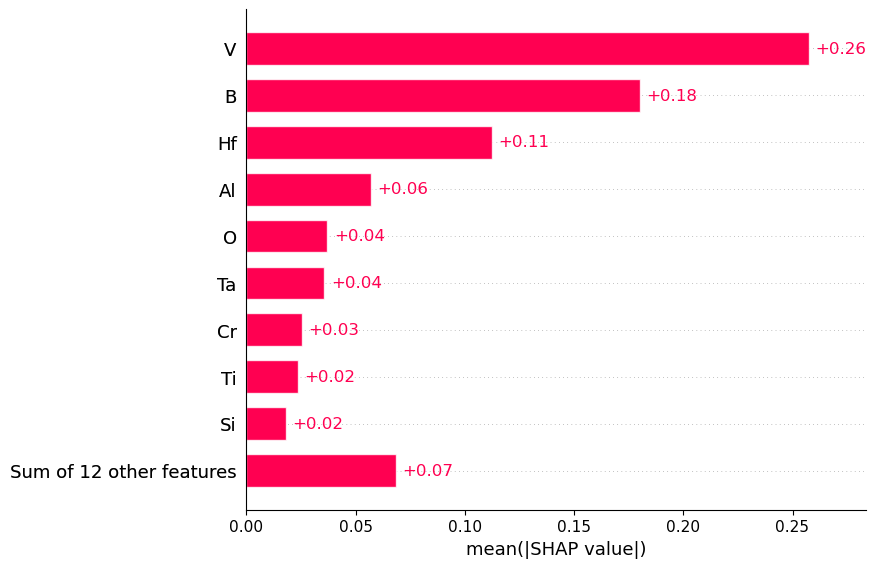

In [45]:
# Mean SHAP for logCost
shap.plots.bar(dnn_shap_values[:,:,3])

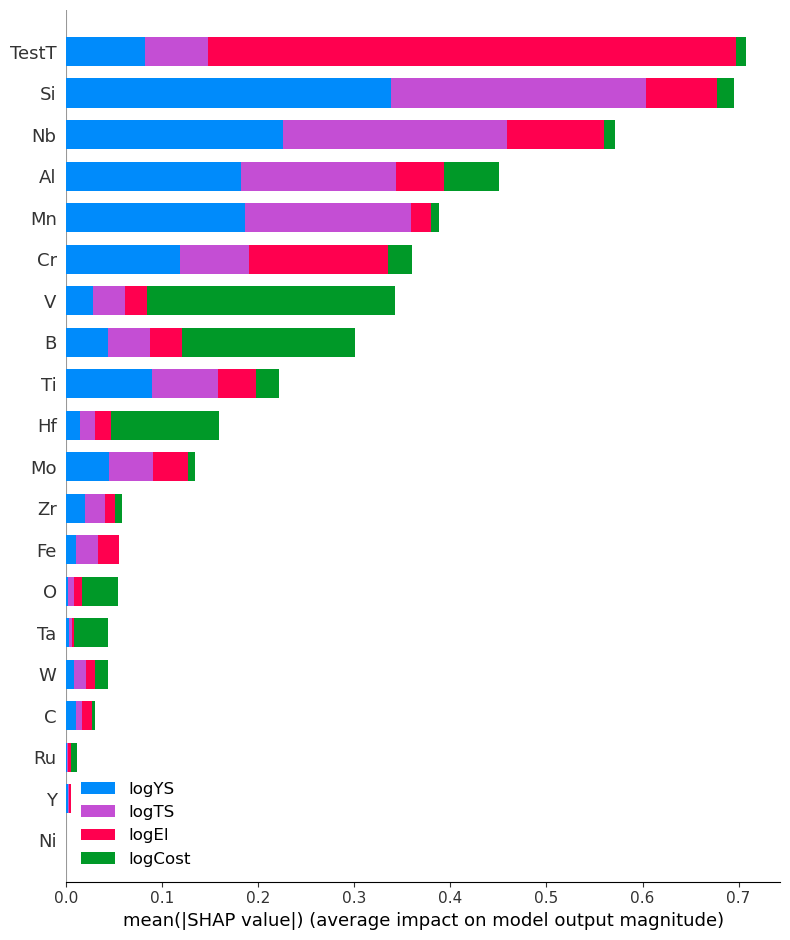

In [46]:
# Overall Summary plot
dnn_shap_list = [dnn_shap_values.values[:,:,0],dnn_shap_values.values[:,:,1],dnn_shap_values.values[:,:,2],dnn_shap_values.values[:,:,3]]
shap.summary_plot(dnn_shap_list, features=X_test.iloc[:100,:], class_names=response)

### Local Interpretations

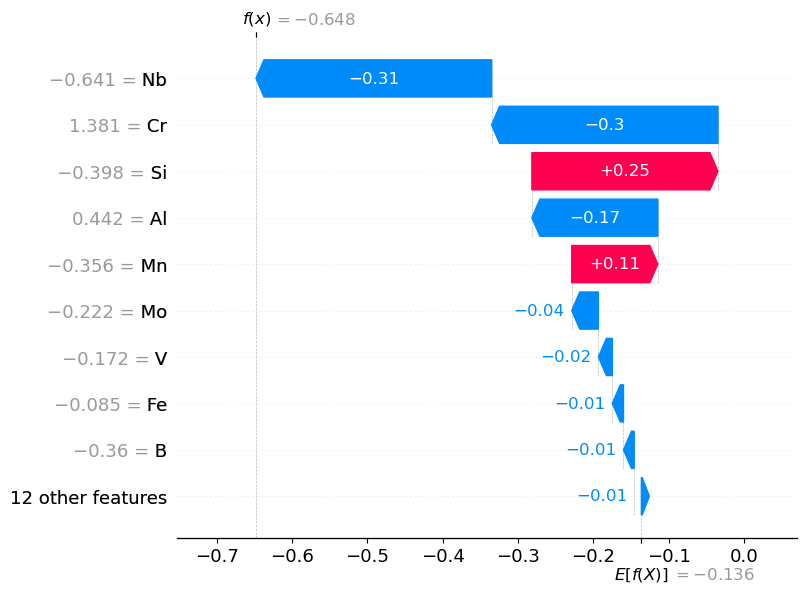

In [47]:
# Waterfall plot for logYS for the first test instance
shap.plots.waterfall(dnn_shap_values[:,:,0][0])

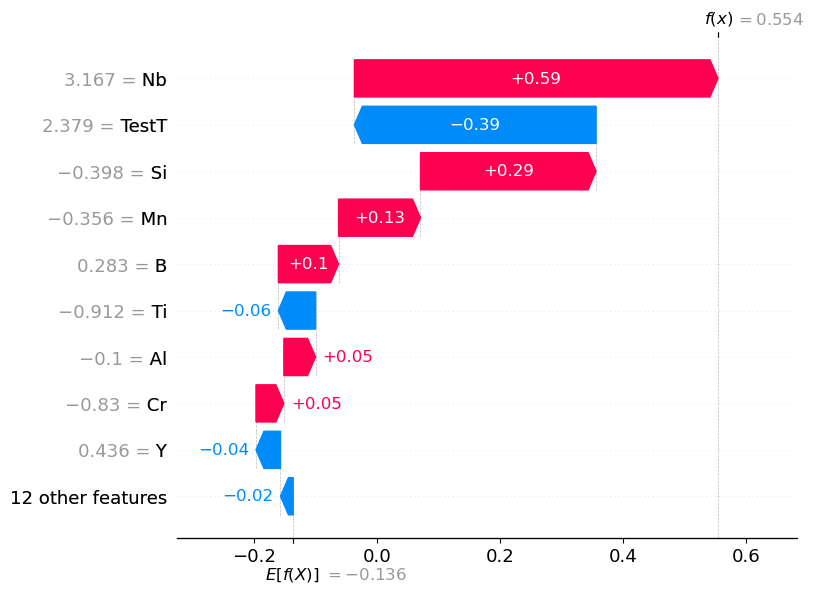

In [48]:
# Waterfall plot for logYS for the 100th test instance
shap.plots.waterfall(dnn_shap_values[:,:,0][99])

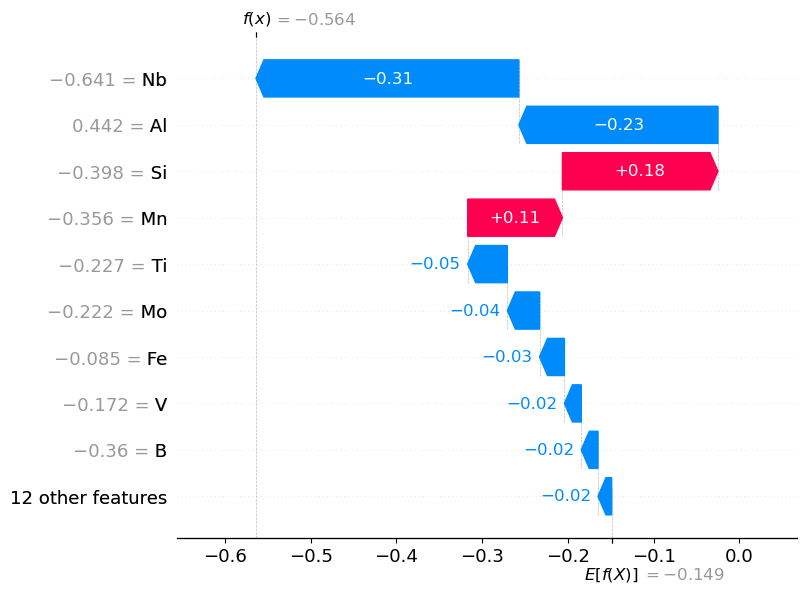

In [49]:
# Waterfall plot for logTS for the first test instance
shap.plots.waterfall(dnn_shap_values[:,:,1][0])

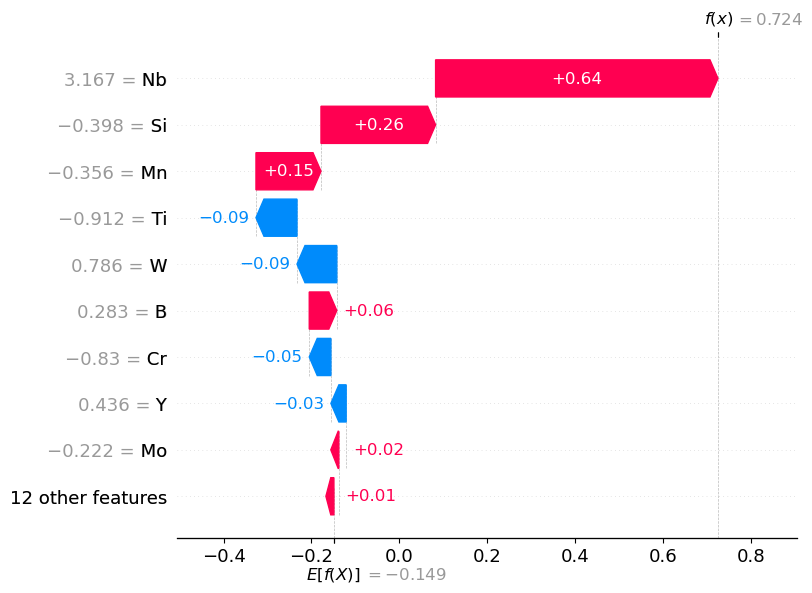

In [50]:
# Waterfall plot for logTS for the 100th test instance
shap.plots.waterfall(dnn_shap_values[:,:,1][99])

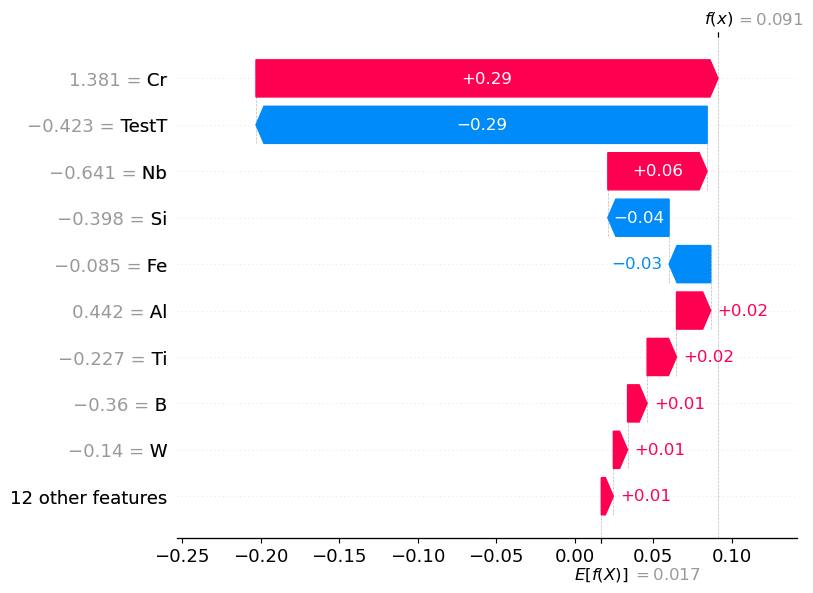

In [51]:
# Waterfall plot for logEl for the first test instance
shap.plots.waterfall(dnn_shap_values[:,:,2][0])

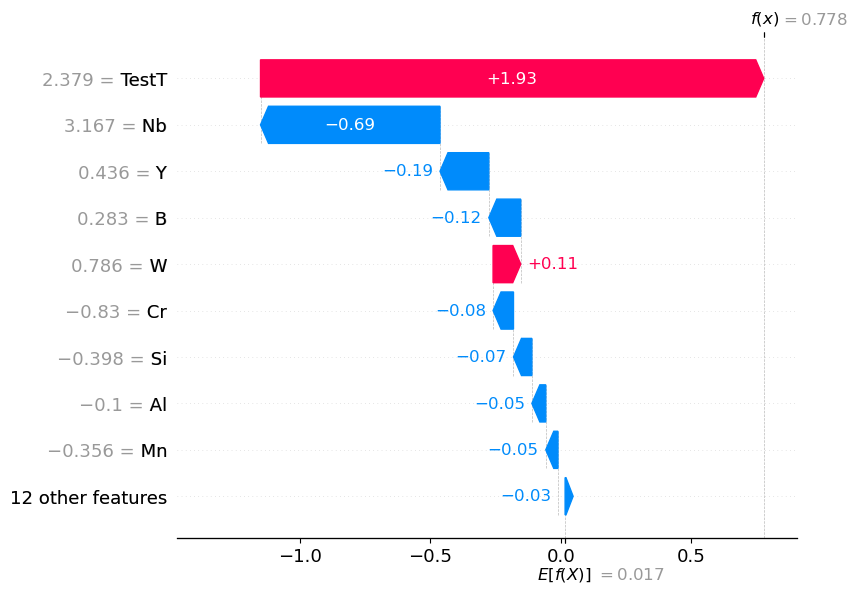

In [52]:
# Waterfall plot for logEl for the 100th test instance
shap.plots.waterfall(dnn_shap_values[:,:,2][99])

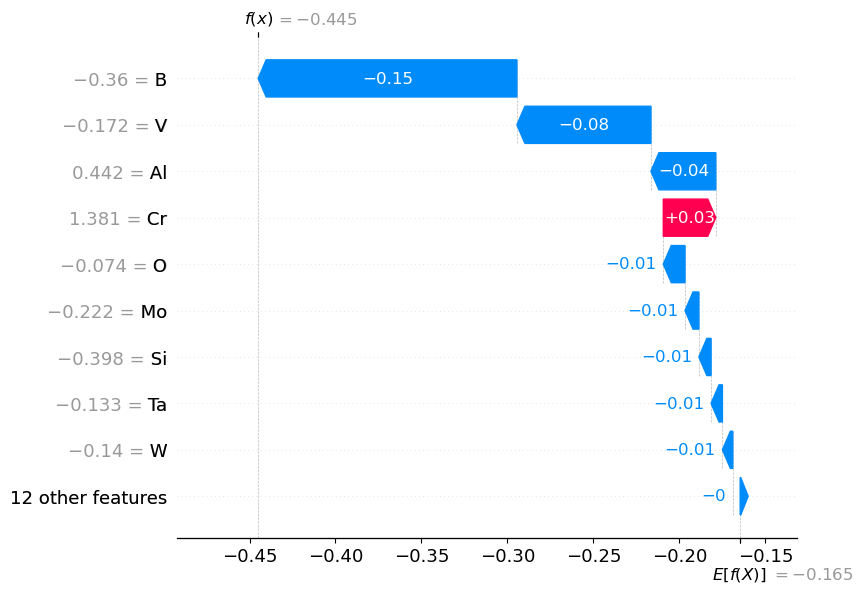

In [53]:
# Waterfall plot for logCost for the first test instance
shap.plots.waterfall(dnn_shap_values[:,:,3][0])

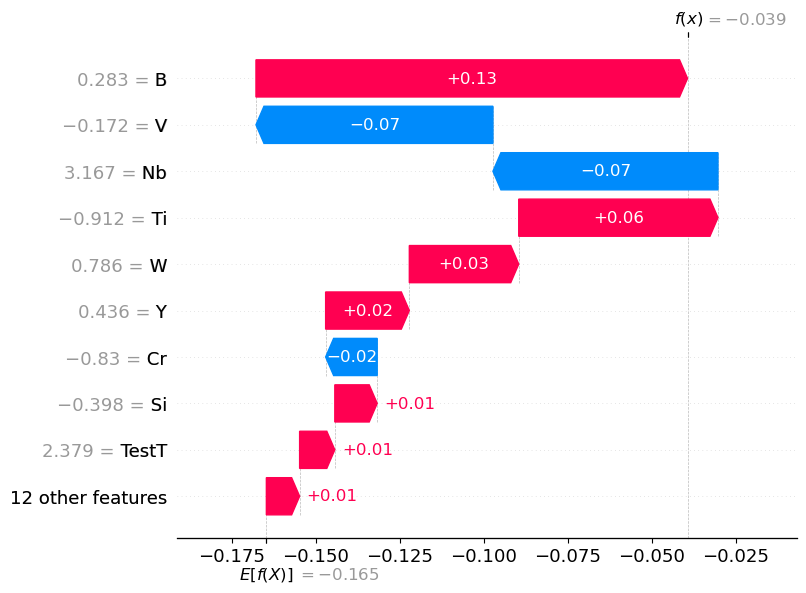

In [54]:
# Waterfall plot for logCost for the 100th test instance
shap.plots.waterfall(dnn_shap_values[:,:,3][99])

### Bayesian Optimization

In [35]:
# Define our search space
x_space = [Real(0.01,100),Real(0.01,100),Integer(0,0.001),Real(0.01,10),Real(0.01,10)]
for i in range(5,20):
    x_space.append(Integer(0,0.001))
x_space.append(Integer(298,298.1))
x_space

[Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='id

In [36]:
def f(X):
    x_init = np.array(X).reshape(1,-1)
    comp = x_init[:-1]/sum(x_init[:-1])*100
    x = np.append(comp,x_init[-1]).reshape(1,-1)
    transformed = scalerX.transform(x)
    y_pred = dnn_rect_model.predict(transformed)
    predicted = scalerY.inverse_transform(y_pred)
    
    target_err_1 = 0
    for i in range(len(target)):
        if target[i] != None:
            target_err_1 = target_err_1 + weight[i]*abs(target[i] - predicted[0][i])
    
    objective = target_err_1
    
    return objective

In [38]:
#Targets
targets = [[np.log10(700),np.log10(900),np.log10(4.5),np.log10(2.5)],
           [np.log10(700),np.log10(900),np.log10(4.5),np.log10(3)]]

In [39]:
targets_df = pd.DataFrame(targets)
targets_df.to_excel("MPR_DNNrect_BO_Targets-RT.xlsx")

In [40]:
weight = [1, 1, 1, 1, 1, 1, 1]

In [41]:
fl_nm=['wCostmod-1','wCostmod-2']
for i in range(len(targets)-2):
    fl_nm.append('wCostmod'+'-'+str(i+2))
fl_nm

['wCostmod-1', 'wCostmod-2']

1/1 [==============================] - 0s 115ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 28ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 7ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 31ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 38ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 7ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 9ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 35ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 31ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 31ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 30ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 28ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 34ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 6ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 30ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 7ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 30ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 28ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


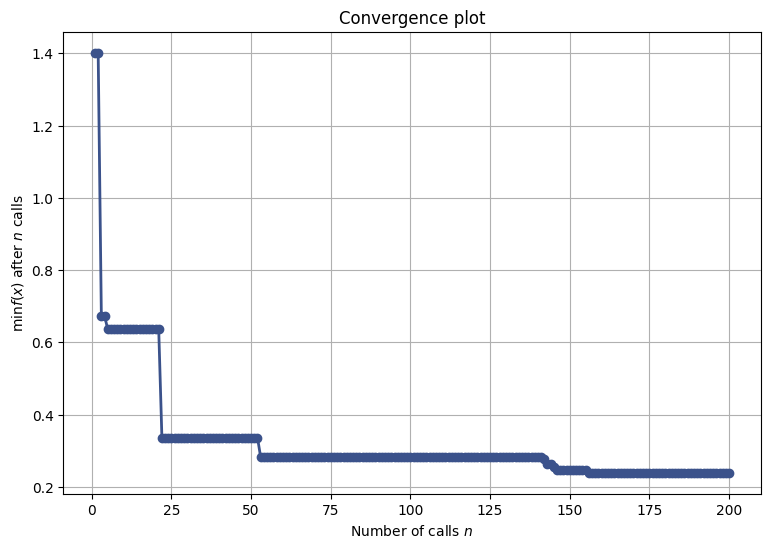

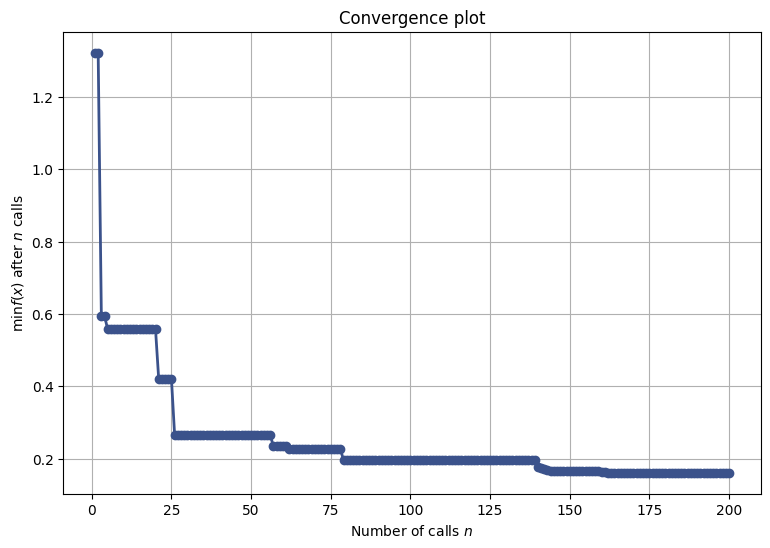

In [42]:
for i in range(len(targets)):
    target = targets[i]
    res = gp_minimize(f,                  # the function to minimize
                      x_space,      # the bounds on each dimension of x
                      acq_func="EI",      # the acquisition function
                      n_calls=200,         # the number of evaluations of f
                      n_random_starts=5,  # the number of random initialization points
                      random_state=42,   # the random seed
                      xi=0.001,           # Exploration or Exploitation
                      n_jobs=-1)
    
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    ax = plot_convergence(res)
    filename = f'Convergence_{i+1}_DNNrect.png'
    fig.savefig('Plots/'+filename)

    for j in range(200):
        results = res.x_iters[j]
        comp_res = np.round(results[:-1]/sum(results[:-1])*100,2)
        results_mod = np.append(comp_res,results[-1])
        temp1 = pd.DataFrame(results_mod.reshape(1,-1), columns=features, index=[j])
        transformed = scalerX.transform(temp1)
        y_pred = dnn_rect_model.predict(transformed)
        predicted = scalerY.inverse_transform(y_pred)
        temp2 = pd.DataFrame(predicted, columns=response, index=[j])
        temp3 = pd.DataFrame(np.round(res.func_vals[j],3), columns = ['Objective'], index=[j])
        if j==0:
            temp_db = pd.concat([temp1,temp2,temp3],axis=1)
        else:
            temp4 = pd.concat([temp1,temp2,temp3],axis=1)
            temp_db = pd.concat([temp_db,temp4],axis=0)
    
    temp_db = temp_db.sort_values('Objective')
    res_df = temp_db.iloc[:10,:]
    temp_db.to_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'.xlsx')
    res_df.to_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'_top10.xlsx')

### Composition 1 Properties Prediction

In [ ]:
c1_data = pd.read_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_wCostmod-1.xlsx')
c1_data = c1_data.iloc[:10,1:22]
c1_data

Ti     Al  Mn    Nb    Cr  Mo  V  Zr  Hf  O  ...  Si  W  C  B  Fe  Ru  \
0  63.67  30.86   0  2.14  3.34   0  0   0   0  0  ...   0  0  0  0   0   0   
1  41.61  48.66   0  4.87  4.87   0  0   0   0  0  ...   0  0  0  0   0   0   
2  44.15  49.47   0  1.43  4.95   0  0   0   0  0  ...   0  0  0  0   0   0   
3  34.44  60.02   0  1.87  3.67   0  0   0   0  0  ...   0  0  0  0   0   0   
4  43.38  48.06   0  4.81  3.76   0  0   0   0  0  ...   0  0  0  0   0   0   
5  40.30  54.01   0  1.62  4.08   0  0   0   0  0  ...   0  0  0  0   0   0   
6  41.85  53.46   0  2.17  2.52   0  0   0   0  0  ...   0  0  0  0   0   0   
7  46.37  49.13   0  1.93  2.57   0  0   0   0  0  ...   0  0  0  0   0   0   
8  39.11  52.89   0  5.29  2.71   0  0   0   0  0  ...   0  0  0  0   0   0   
9  47.33  47.33   0  2.92  2.43   0  0   0   0  0  ...   0  0  0  0   0   0   

   Ni  Y  Re  TestT  
0   0  0   0    298  
1   0  0   0    298  
2   0  0   0    298  
3   0  0   0    298  
4   0  0   0    298  
5   0  0   0    298  
6   0  0   0    298  
7   0  0   0    298  
8   0  0   0    298  
9   0  0   0    298  

[10 rows x 21 columns]

In [ ]:
c1_mean = round(c1_data.mean(axis=0),2)
c1_mean

Ti        44.22
Al        49.39
Mn         0.00
Nb         2.90
Cr         3.49
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [ ]:
c1_mean_scaled = scalerX.transform(c1_mean.values.reshape(1,-1))
c1_prop_scaled = rfregressor.predict(c1_mean_scaled)
c1_prop = scalerY.inverse_transform(c1_prop_scaled)
c1_prop = np.round(10**c1_prop, 2)
c1_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[498.32, 580.  ,   0.67,   4.25]])

In [ ]:
c1_prop_df = pd.DataFrame(c1_prop, columns=['YS','TS','El','Cost'])
c1_prop_df

YS     TS    El  Cost
0  498.32  580.0  0.67  4.25

In [ ]:
c1_prop_df.to_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_wCostmod-1_top10_Properties.xlsx')

### Composition 2 Properties Prediction

In [ ]:
c2_data = pd.read_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_wCostmod-2.xlsx')
c2_data = c2_data.iloc[:10,1:22]
c2_data

Ti     Al  Mn    Nb    Cr  Mo  V  Zr  Hf  O  ...  Si  W  C  B  Fe  Ru  \
0  63.67  30.86   0  2.14  3.34   0  0   0   0  0  ...   0  0  0  0   0   0   
1  44.37  48.12   0  4.81  2.70   0  0   0   0  0  ...   0  0  0  0   0   0   
2  37.42  56.13   0  1.73  4.72   0  0   0   0  0  ...   0  0  0  0   0   0   
3  55.22  35.14   0  4.02  5.63   0  0   0   0  0  ...   0  0  0  0   0   0   
4  47.90  45.54   0  2.91  3.66   0  0   0   0  0  ...   0  0  0  0   0   0   
5  37.84  53.42   0  5.34  3.40   0  0   0   0  0  ...   0  0  0  0   0   0   
6  40.56  54.67   0  1.98  2.79   0  0   0   0  0  ...   0  0  0  0   0   0   
7  47.71  47.70   0  1.41  3.19   0  0   0   0  0  ...   0  0  0  0   0   0   
8  38.36  53.19   0  3.13  5.32   0  0   0   0  0  ...   0  0  0  0   0   0   
9  47.28  47.28   0  2.08  3.35   0  0   0   0  0  ...   0  0  0  0   0   0   

   Ni  Y  Re  TestT  
0   0  0   0    298  
1   0  0   0    298  
2   0  0   0    298  
3   0  0   0    298  
4   0  0   0    298  
5   0  0   0    298  
6   0  0   0    298  
7   0  0   0    298  
8   0  0   0    298  
9   0  0   0    298  

[10 rows x 21 columns]

In [ ]:
c2_mean = round(c2_data.mean(axis=0),2)
c2_mean

Ti        46.03
Al        47.21
Mn         0.00
Nb         2.95
Cr         3.81
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [ ]:
c2_mean_scaled = scalerX.transform(c2_mean.values.reshape(1,-1))
c2_prop_scaled = rfregressor.predict(c2_mean_scaled)
c2_prop = scalerY.inverse_transform(c2_prop_scaled)
c2_prop = np.round(10**c2_prop, 2)
c2_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[490.68, 582.31,   1.01,   4.86]])

In [ ]:
c2_prop_df = pd.DataFrame(c2_prop, columns=['YS','TS','El','Cost'])
c2_prop_df

YS      TS    El  Cost
0  490.68  582.31  1.01  4.86

In [ ]:
c2_prop_df.to_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_wCostmod-2_top10_Properties.xlsx')

### Reference Composition Properties

In [ ]:
ref_comp = [48, 48, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298]
ref_comp = np.array(ref_comp).reshape(1,-1)
ref_comp_df = pd.DataFrame(ref_comp, columns=features)
ref_comp_df

Ti  Al  Mn  Nb  Cr  Mo  V  Zr  Hf  O  ...  Si  W  C  B  Fe  Ru  Ni  Y  Re  \
0  48  48   0   2   2   0  0   0   0  0  ...   0  0  0  0   0   0   0  0   0   

   TestT  
0    298  

[1 rows x 21 columns]

In [ ]:
ref_comp_scaled = scalerX.transform(ref_comp)
ref_prop_scaled = rfregressor.predict(ref_comp_scaled)
ref_prop = scalerY.inverse_transform(ref_prop_scaled)
ref_prop = np.round(10**ref_prop, 2)
ref_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[456.61, 517.94,   0.52,   3.87]])

In [ ]:
ref_prop_df = pd.DataFrame(ref_prop, columns=['YS','TS','El','Cost'])
ref_prop_df

YS      TS    El  Cost
0  456.61  517.94  0.52  3.87

In [ ]:
ref_prop_df.to_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_Ref_Properties.xlsx')